# EDA: panel_close.parquet — Preparação para ML/DL/RL

Este notebook realiza uma análise exploratória detalhada do painel de preços de fechamento (`00_data/02_curado/panel_close.parquet`) para preparar os dados para usos em ML, DL e RL.

Objetivos:
- Verificar estrutura (formato long x wide), tipos e integridade dos dados.
- Normalizar para um painel Date × Ativo com valores de preço.
- Avaliar cobertura e faltas (missing), continuidade e frequência temporal.
- Calcular retornos (simples e log), estatísticas e correlações.
- (Opcional) Verificar estacionariedade de algumas séries.

Ao final, teremos insumos claros para feature engineering, modelagem e simulações.

In [1]:
# Setup
# - Imports essenciais
# - Configurações de visualização
# - Checagem de versões

import os
from pathlib import Path
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

print({
    'python': sys.version.split()[0],
    'pandas': pd.__version__,
    'numpy' : np.__version__,
})

# Estilos de plot
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Raiz do projeto (ajuste caso necessário)
PROJECT_ROOT = Path(r"g:/Drives compartilhados/BOLSA_2026/a_bolsa2026_gemini").resolve()
DATA_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'panel_close.parquet'
print('DATA_PATH:', DATA_PATH)
print('Exists?', DATA_PATH.exists())

{'python': '3.11.13', 'pandas': '2.2.3', 'numpy': '2.2.5'}
DATA_PATH: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\panel_close.parquet
Exists? True


In [2]:
# Verificação de dependências mínimas para leitura e EDA
# Observação: Evitamos instalar pacotes automaticamente.
# Se faltar algo (ex.: pyarrow/fastparquet), imprima uma instrução para instalar no ambiente.

required = {
    'pandas': pd.__version__,
    'numpy': np.__version__,
}

# pandas usa 'pyarrow' ou 'fastparquet' para parquet
try:
    import pyarrow as _pa  # noqa: F401
    engine_msg = 'pyarrow'
except Exception:
    try:
        import fastparquet as _fp  # noqa: F401
        engine_msg = 'fastparquet'
    except Exception:
        engine_msg = None

print('Parquet engine:', engine_msg or 'MISSING')
if engine_msg is None:
    print('\n[ATENÇÃO] Nenhum engine parquet encontrado. Instale uma das opções:')
    print(' - pip install pyarrow')
    print(' - pip install fastparquet')

Parquet engine: pyarrow


In [3]:
# Carregamento do dataset: panel_close.parquet

assert DATA_PATH.exists(), f"Arquivo não encontrado: {DATA_PATH}"

# Tentativa de leitura com o melhor engine disponível
_read_kwargs = {}
try:
    import pyarrow as _pa  # noqa: F401
    _read_kwargs['engine'] = 'pyarrow'
except Exception:
    try:
        import fastparquet as _fp  # noqa: F401
        _read_kwargs['engine'] = 'fastparquet'
    except Exception:
        _read_kwargs = {}

panel = pd.read_parquet(DATA_PATH, **_read_kwargs)
print('shape:', panel.shape)
print('columns:', list(panel.columns))
print('dtypes:\n', panel.dtypes)
print('\nhead:')
display(panel.head())

# Amostra aleatória pequena para inspeção
display(panel.sample(min(5, len(panel)), random_state=42))

shape: (3547, 32)
columns: ['date', 'ABEV3.SA', 'B3SA3.SA', 'BBAS3.SA', 'CPLE6.SA', 'CSNA3.SA', 'ELET3.SA', 'GGBR4.SA', 'HAPV3.SA', 'ITUB4.SA', 'LREN3.SA', 'PETR4.SA', 'PRIO3.SA', 'PSSA3.SA', 'RAIL3.SA', 'RDOR3.SA', 'SBSP3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'VALE3.SA', 'VIVT3.SA', 'WEGE3.SA', '_bvsp', '_gspc', '_tnx', '_vix', 'bz=f', 'dx-y.nyb', 'ewz']
dtypes:
 date         datetime64[ns]
ABEV3.SA            float64
B3SA3.SA            float64
BBAS3.SA            float64
CPLE6.SA            float64
CSNA3.SA            float64
ELET3.SA            float64
GGBR4.SA            float64
HAPV3.SA            float64
ITUB4.SA            float64
LREN3.SA            float64
PETR4.SA            float64
PRIO3.SA            float64
PSSA3.SA            float64
RAIL3.SA            float64
RDOR3.SA            float64
SBSP3.SA            float64
SUZB3.SA            float64
TAEE11.SA           float64
TIMS3.SA            float64
TOTS3.SA            float64
UGPA3.SA         

,date,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
0,2012-01-02,10.872475,3.250000,12.145,3.828924,15.11,17.643295,11.587301,NaN,14.086635,...,40.900002,23.730000,2.760355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-03,10.748561,3.306666,12.090,3.733951,15.89,17.883204,12.023809,NaN,14.438490,...,42.720001,23.360001,2.825443,59265.0,1277.060059,1.960,22.969999,112.129997,79.610001,59.700001
2,2012-01-04,10.498734,3.366666,12.030,3.766942,16.00,18.682899,12.222222,NaN,14.455048,...,43.009998,23.670000,2.840236,59365.0,1277.300049,1.995,22.219999,113.699997,80.089996,59.919998
3,2012-01-05,10.290878,3.330000,11.905,3.778938,15.87,18.303043,12.420634,NaN,14.347422,...,41.860001,23.350000,2.857988,58546.0,1281.060059,1.993,21.480000,112.739998,80.940002,59.110001
4,2012-01-06,10.264896,3.380000,11.605,3.818927,15.83,18.133108,12.539682,NaN,14.455048,...,41.500000,22.820000,2.825443,58600.0,1277.810059,1.961,20.629999,113.059998,81.239998,58.520000


,date,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
299,2013-02-28,17.456394,4.470000,13.170000,2.899185,10.000000,6.947360,13.055555,NaN,14.508861,...,37.799999,23.004999,3.918639,57424.0,1514.680054,1.888,15.510000,111.379997,81.980003,55.130001
2550,2021-11-22,17.320000,12.100000,14.445000,6.108284,21.799999,32.070000,20.182539,191.550003,20.063637,...,67.589996,25.959999,34.669998,102122.0,4682.939941,1.625,19.170000,79.699997,96.500000,29.160000
3079,2023-12-07,14.080000,13.290000,26.934999,9.560000,16.969999,41.529999,18.591665,64.199997,28.745455,...,72.599998,26.615000,35.360001,126010.0,4585.589844,4.129,13.060000,74.050003,103.540001,33.599998
2342,2021-02-01,15.600000,20.416666,17.145000,6.538163,31.690001,30.830000,18.444445,262.649994,26.436363,...,91.269997,22.965000,42.270000,117365.0,3773.860107,1.077,30.240000,56.349998,91.019997,34.919998
1211,2016-09-14,19.660000,5.523333,10.965000,3.232092,8.260000,21.841700,6.936507,NaN,19.300276,...,16.639999,18.700001,6.419230,57059.0,2125.770020,1.689,18.139999,45.849998,95.330002,31.969999


In [4]:
# Normalização do painel para formato: index=DateTime, columns=Ticker, values=Close

panel_cols = {c.lower(): c for c in panel.columns}
has_date = any(c.lower() in ('date', 'datetime', 'dt') for c in panel.columns)
has_ticker = any(c.lower() in ('ticker', 'symbol', 'ativo', 'asset') for c in panel.columns)

if has_date and has_ticker and 'close' in panel_cols:
    # Provável formato long: [date, ticker, close]
    date_col = next(c for c in panel.columns if c.lower() in ('date','datetime','dt'))
    ticker_col = next(c for c in panel.columns if c.lower() in ('ticker','symbol','ativo','asset'))
    close_col = panel_cols['close']
    panel_norm = panel[[date_col, ticker_col, close_col]].copy()
    panel_norm[date_col] = pd.to_datetime(panel_norm[date_col])
    wide = panel_norm.pivot_table(index=date_col, columns=ticker_col, values=close_col)
else:
    # Provável formato wide já (primeira coluna pode ser data)
    # Tenta identificar coluna de data ou usa o index
    if has_date:
        date_col = next(c for c in panel.columns if c.lower() in ('date','datetime','dt'))
        tmp = panel.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        tmp = tmp.set_index(date_col)
        # remove colunas não numéricas (ex.: metadata)
        num_cols = tmp.select_dtypes(include=[np.number]).columns
        wide = tmp[num_cols].copy()
    else:
        tmp = panel.copy()
        # se o index for datetime-like, use; caso contrário, tente converter
        if not isinstance(tmp.index, pd.DatetimeIndex):
            try:
                tmp.index = pd.to_datetime(tmp.index)
            except Exception:
                pass
        num_cols = tmp.select_dtypes(include=[np.number]).columns
        wide = tmp[num_cols].copy()

# Ordena pelo índice temporal e remove colunas vazias
wide = wide.sort_index()
wide = wide.loc[:, wide.notna().any()]  # mantém colunas com pelo menos 1 valor

print('Painel normalizado (wide) -> shape:', wide.shape)
display(wide.head())
print('Datas min/max:', wide.index.min(), '->', wide.index.max())
print('Número de ativos (colunas):', wide.shape[1])
print('Frequência inferida:', pd.infer_freq(wide.index))

Painel normalizado (wide) -> shape: (3547, 31)


,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,LREN3.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,10.872475,3.250000,12.145,3.828924,15.11,17.643295,11.587301,NaN,14.086635,6.911623,...,40.900002,23.730000,2.760355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,10.748561,3.306666,12.090,3.733951,15.89,17.883204,12.023809,NaN,14.438490,6.884519,...,42.720001,23.360001,2.825443,59265.0,1277.060059,1.960,22.969999,112.129997,79.610001,59.700001
2012-01-04,10.498734,3.366666,12.030,3.766942,16.00,18.682899,12.222222,NaN,14.455048,6.812692,...,43.009998,23.670000,2.840236,59365.0,1277.300049,1.995,22.219999,113.699997,80.089996,59.919998
2012-01-05,10.290878,3.330000,11.905,3.778938,15.87,18.303043,12.420634,NaN,14.347422,7.044435,...,41.860001,23.350000,2.857988,58546.0,1281.060059,1.993,21.480000,112.739998,80.940002,59.110001
2012-01-06,10.264896,3.380000,11.605,3.818927,15.83,18.133108,12.539682,NaN,14.455048,7.142011,...,41.500000,22.820000,2.825443,58600.0,1277.810059,1.961,20.629999,113.059998,81.239998,58.520000


Datas min/max: 2012-01-02 00:00:00 -> 2025-10-01 00:00:00
Número de ativos (colunas): 31
Frequência inferida: None


Cobertura média por ativo: 0.9231
Cobertura min/max: 0.3363 / 0.9746


,coverage
RDOR3.SA,0.336341
HAPV3.SA,0.520440
RAIL3.SA,0.736397
_bvsp,0.960530
CPLE6.SA,0.962504
ELET3.SA,0.962785
CSNA3.SA,0.962785
GGBR4.SA,0.962785
TAEE11.SA,0.962785
UGPA3.SA,0.962785


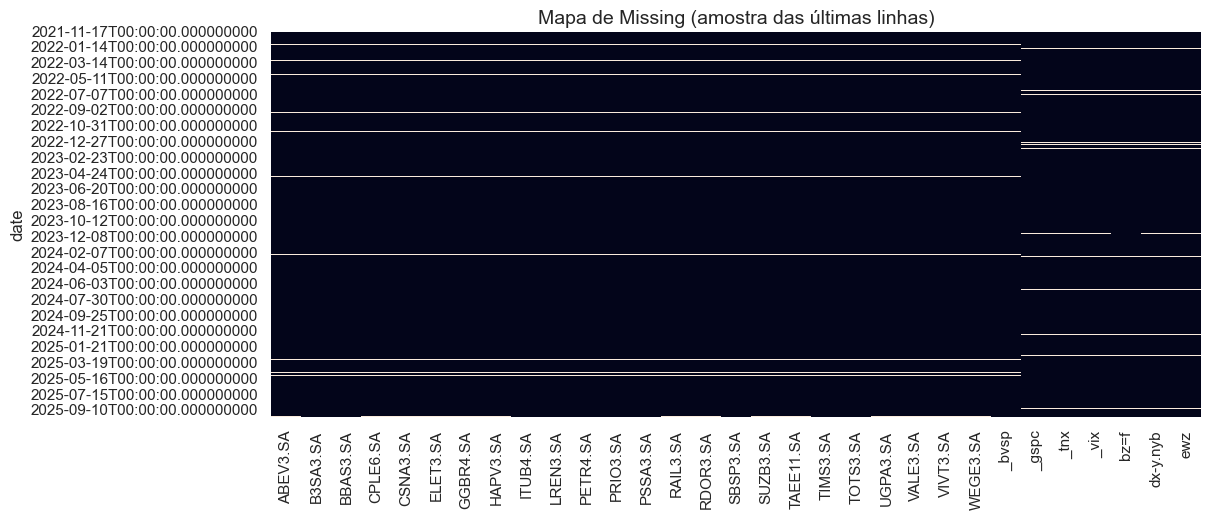

Dias úteis esperados: 3588
Datas ausentes no índice vs. BDay: 41
Exemplos de datas ausentes: [Timestamp('2012-02-20 00:00:00'), Timestamp('2012-04-06 00:00:00'), Timestamp('2012-12-25 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2013-03-29 00:00:00'), Timestamp('2013-12-25 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-18 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-01-01 00:00:00')]


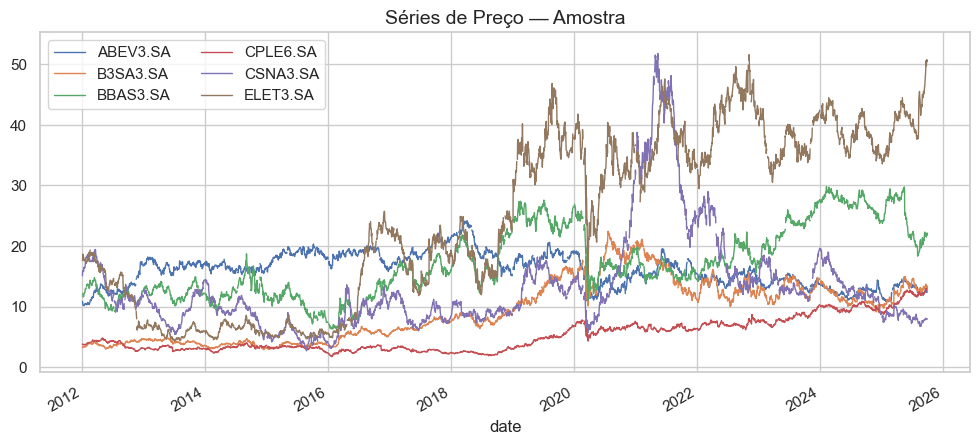

In [6]:
# Cobertura, faltas e frequência

n_rows, n_cols = wide.shape
missing_by_col = wide.isna().sum()
coverage_by_col = 1 - missing_by_col / n_rows

print('Cobertura média por ativo:', coverage_by_col.mean().round(4))
print('Cobertura min/max:', coverage_by_col.min().round(4), '/', coverage_by_col.max().round(4))

display(coverage_by_col.sort_values(ascending=True).to_frame('coverage'))

# Visualização da matriz de missing (amostra para não pesar)
subset = wide.iloc[-min(1000, n_rows):]  # últimas 1000 linhas
plt.figure(figsize=(12, 5))
sns.heatmap(subset.isna(), cbar=False)
plt.title('Mapa de Missing (amostra das últimas linhas)')
plt.show()

# Checagem de frequência por dias úteis
bday_index = pd.bdate_range(start=wide.index.min(), end=wide.index.max())
missing_dates = bday_index.difference(wide.index)
print('Dias úteis esperados:', len(bday_index))
print('Datas ausentes no índice vs. BDay:', len(missing_dates))
if len(missing_dates) > 0:
    print('Exemplos de datas ausentes:', list(missing_dates[:10]))

# Visualização de algumas séries
sample_cols = list(wide.columns[: min(6, n_cols)])
wide[sample_cols].plot(subplots=False, linewidth=1)
plt.title('Séries de Preço — Amostra')
plt.legend(loc='upper left', ncol=2)
plt.show()

returns shape: (3547, 31) | logret shape: (3547, 31)


C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\4104020384.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = wide.pct_change().replace([np.inf, -np.inf], np.nan)


,count,mean,std,skew,kurt,min,max
_vix,3545,0.0030,0.0821,2.3850,19.2227,-0.3575,1.1560
PRIO3.SA,3546,0.0013,0.0443,2.4892,46.3044,-0.3654,0.8367
CSNA3.SA,3546,0.0004,0.0345,0.3933,4.4562,-0.2529,0.2082
HAPV3.SA,1917,0.0001,0.0330,-0.4968,15.6640,-0.3356,0.2732
ELET3.SA,3546,0.0008,0.0308,1.5038,24.3525,-0.2097,0.4930
UGPA3.SA,3546,0.0007,0.0300,17.8137,710.8320,-0.2136,1.1933
PETR4.SA,3546,0.0005,0.0283,-0.4705,9.3434,-0.2970,0.2222
RAIL3.SA,2709,0.0004,0.0283,-0.1773,11.8861,-0.2574,0.2211
_tnx,3545,0.0006,0.0282,1.8802,46.4664,-0.2932,0.4990
GGBR4.SA,3546,0.0004,0.0260,0.1519,3.9807,-0.1796,0.1745


Amostra ABEV3.SA: outliers=25 | limites=(-0.0552, 0.0552)


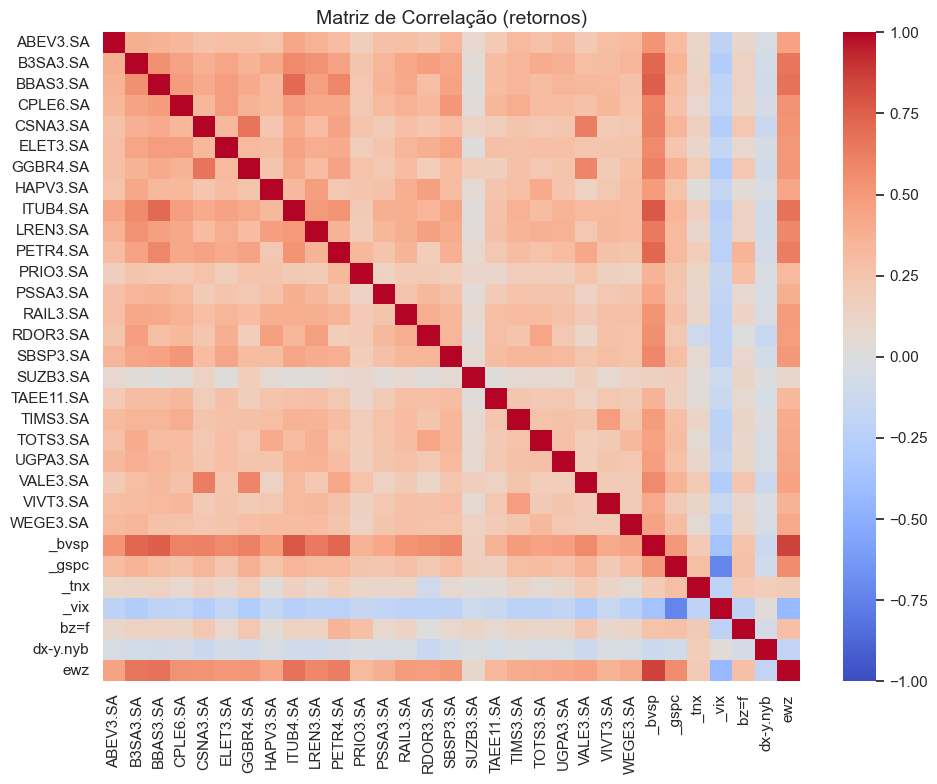

,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,LREN3.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
count,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,...,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000
mean,0.2872,0.3713,0.3702,0.3384,0.3111,0.3111,0.3173,0.2838,0.3747,0.3438,...,0.2710,0.2550,0.2550,0.4899,0.2764,0.1349,-0.1909,0.1596,-0.0281,0.4367
std,0.1963,0.2330,0.2390,0.2124,0.2282,0.2091,0.2231,0.2023,0.2420,0.2197,...,0.2254,0.1846,0.1902,0.2694,0.2510,0.1864,0.2523,0.1921,0.2012,0.2675
min,-0.2158,-0.2791,-0.2042,-0.1964,-0.2699,-0.1683,-0.2828,-0.1714,-0.2562,-0.2169,...,-0.2764,-0.1500,-0.2450,-0.3749,-0.7315,-0.2057,-0.7315,-0.2185,-0.1928,-0.4309
25%,0.2306,0.2979,0.2967,0.2702,0.2266,0.2436,0.2275,0.2297,0.3000,0.2909,...,0.1842,0.2032,0.2002,0.4227,0.2415,0.0743,-0.2506,0.0859,-0.0902,0.3732
50%,0.2911,0.3793,0.3472,0.3398,0.2672,0.2924,0.2878,0.2670,0.3731,0.3605,...,0.2384,0.2444,0.2580,0.5272,0.2908,0.1078,-0.2089,0.1225,-0.0599,0.4585
75%,0.3456,0.4508,0.4727,0.4404,0.3940,0.4252,0.3943,0.3612,0.4620,0.4478,...,0.3204,0.3078,0.3036,0.6122,0.3326,0.1832,-0.1729,0.2311,-0.0428,0.5440
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [7]:
# Retornos, estatísticas e correlações

# Retornos simples e log
returns = wide.pct_change().replace([np.inf, -np.inf], np.nan)
logret = np.log(wide).diff().replace([np.inf, -np.inf], np.nan)

print('returns shape:', returns.shape, '| logret shape:', logret.shape)

# Estatísticas agregadas
summary = pd.DataFrame({
    'count': returns.count(),
    'mean': returns.mean(),
    'std': returns.std(),
    'skew': returns.skew(),
    'kurt': returns.kurt(),
    'min': returns.min(),
    'max': returns.max(),
})
display(summary.sort_values('std', ascending=False).round(4))

# Outliers por IQR (amostra de uma série)
sample = returns.columns[0] if returns.shape[1] > 0 else None
if sample is not None:
    s = returns[sample].dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 3*iqr, q3 + 3*iqr
    outliers = s[(s < lower) | (s > upper)]
    print(f'Amostra {sample}: outliers={len(outliers)} | limites=({lower:.4f}, {upper:.4f})')

# Correlações (Pearson) em janela completa
corr = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Matriz de Correlação (retornos)')
plt.tight_layout()
plt.show()

display(corr.describe().round(4))

In [ ]:
# Instalação opcional para testes ADF
# Se o ambiente permitir instalação via pip no notebook, descomente e rode.
# Em ambientes corporativos/conda, prefira instalar via terminal do ambiente.
%pip install -q --disable-pip-version-check statsmodels

In [13]:
# (Opcional) Testes de estacionariedade ADF para algumas séries de retornos

try:
    from statsmodels.tsa.stattools import adfuller
    has_adf = True
except Exception:
    has_adf = False

if not has_adf:
    print('[INFO] statsmodels não disponível. Para testes ADF: pip install statsmodels')
else:
    sel = list(returns.columns[: min(5, returns.shape[1])])
    results = []
    for col in sel:
        s = returns[col].dropna()
        if len(s) < 20:
            continue
        stat, pval, usedlag, nobs, crit, icbest = adfuller(s.values, autolag='AIC')
        results.append({
            'series': col,
            'nobs': int(nobs),
            'stat': stat,
            'pval': pval,
            'crit_1%': crit.get('1%'),
            'crit_5%': crit.get('5%'),
            'crit_10%': crit.get('10%'),
        })
    if results:
        display(pd.DataFrame(results).set_index('series').round(4))
    else:
        print('Sem séries suficientes para ADF.')

,nobs,stat,pval,crit_1%,crit_5%,crit_10%
series,,,,,,
ABEV3.SA,3542,-31.3162,0.0,-3.4322,-2.8624,-2.5672
B3SA3.SA,3540,-24.9946,0.0,-3.4322,-2.8624,-2.5672
BBAS3.SA,3539,-22.4261,0.0,-3.4322,-2.8624,-2.5672
CPLE6.SA,3533,-17.0836,0.0,-3.4322,-2.8624,-2.5672
CSNA3.SA,3545,-58.6827,0.0,-3.4322,-2.8624,-2.5672


In [14]:
# Verificação: os dias úteis ausentes são ausentes para TODOS os tickers?
# Resultado esperado: se o dia não está no índice (missing_dates), então não há dados para nenhum ticker.
# Além disso, verificamos se há dias presentes no índice mas com todos valores NaN (tabela vazia naquele dia).

assert 'wide' in globals(), 'Variável wide indisponível. Execute as células anteriores.'
assert 'bday_index' in globals(), 'Variável bday_index indisponível. Execute a célula de cobertura/missing.'
assert 'missing_dates' in globals(), 'Variável missing_dates indisponível. Execute a célula de cobertura/missing.'

check = pd.DataFrame(index=bday_index)
check['in_panel'] = check.index.isin(wide.index)

# Contagem de valores não NaN por dia (somente onde o dia existe no painel)
intersection = wide.index.intersection(bday_index)
non_na_counts = wide.loc[intersection].notna().sum(axis=1)
check.loc[intersection, 'non_na_count'] = non_na_counts
check['non_na_count'] = check['non_na_count'].fillna(0).astype(int)

# Dias que estão faltando para todos os tickers:
check['all_missing'] = (~check['in_panel']) | (check['non_na_count'] == 0)

# Foco nos 41 dias reportados
mdf = check.loc[missing_dates].copy()

print('Total dias úteis no período:', len(bday_index))
print('Total dias ausentes (bday_index - wide.index):', len(missing_dates))
print('\nResumo dos dias ausentes:')
print(mdf[['in_panel', 'non_na_count', 'all_missing']].head(15))

all_absent_for_all = (mdf['in_panel'].eq(False) & mdf['non_na_count'].eq(0)).all()
print('\nTodos os dias ausentes estão ausentes para todos os tickers?', bool(all_absent_for_all))

# Extra: dias que existem no índice mas com todos NaN (se houver)
present_all_nan = check.query('in_panel and non_na_count == 0')
print('Dias presentes mas com todos NaN:', len(present_all_nan))
if len(present_all_nan) > 0:
    display(present_all_nan.head(10))

Total dias úteis no período: 3588
Total dias ausentes (bday_index - wide.index): 41

Resumo dos dias ausentes:
            in_panel  non_na_count  all_missing
2012-02-20     False             0         True
2012-04-06     False             0         True
2012-12-25     False             0         True
2013-01-01     False             0         True
2013-03-29     False             0         True
2013-12-25     False             0         True
2014-01-01     False             0         True
2014-04-18     False             0         True
2014-12-25     False             0         True
2015-01-01     False             0         True
2015-02-16     False             0         True
2015-04-03     False             0         True
2015-09-07     False             0         True
2015-12-25     False             0         True
2016-01-01     False             0         True

Todos os dias ausentes estão ausentes para todos os tickers? True
Dias presentes mas com todos NaN: 0


In [15]:
# Carregar e normalizar o painel de volume: panel_volume.parquet -> wide_vol
VOLUME_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'panel_volume.parquet'
print('VOLUME_PATH:', VOLUME_PATH, '| Exists?', VOLUME_PATH.exists())

_read_kwargs_vol = {}
try:
    import pyarrow as _pa  # noqa: F401
    _read_kwargs_vol['engine'] = 'pyarrow'
except Exception:
    try:
        import fastparquet as _fp  # noqa: F401
        _read_kwargs_vol['engine'] = 'fastparquet'
    except Exception:
        _read_kwargs_vol = {}

panel_vol = pd.read_parquet(VOLUME_PATH, **_read_kwargs_vol)
print('panel_vol shape:', panel_vol.shape)
print('panel_vol columns:', list(panel_vol.columns))

# Detecção de estrutura e normalização para wide_vol
panel_vol_cols = {c.lower(): c for c in panel_vol.columns}
vol_has_date = any(c.lower() in ('date', 'datetime', 'dt') for c in panel_vol.columns)
vol_has_ticker = any(c.lower() in ('ticker', 'symbol', 'ativo', 'asset') for c in panel_vol.columns)

# heurística: coluna de volume pode se chamar 'volume' ou 'vol'
vol_value_col = None
for k in ('volume','vol'):
    if k in panel_vol_cols:
        vol_value_col = panel_vol_cols[k]
        break

if vol_has_date and vol_has_ticker and vol_value_col is not None:
    date_col_v = next(c for c in panel_vol.columns if c.lower() in ('date','datetime','dt'))
    ticker_col_v = next(c for c in panel_vol.columns if c.lower() in ('ticker','symbol','ativo','asset'))
    vol_col_v = vol_value_col
    panel_vol_norm = panel_vol[[date_col_v, ticker_col_v, vol_col_v]].copy()
    panel_vol_norm[date_col_v] = pd.to_datetime(panel_vol_norm[date_col_v])
    wide_vol = panel_vol_norm.pivot_table(index=date_col_v, columns=ticker_col_v, values=vol_col_v)
else:
    tmpv = panel_vol.copy()
    if vol_has_date:
        date_col_v = next(c for c in panel_vol.columns if c.lower() in ('date','datetime','dt'))
        tmpv[date_col_v] = pd.to_datetime(tmpv[date_col_v])
        tmpv = tmpv.set_index(date_col_v)
    else:
        if not isinstance(tmpv.index, pd.DatetimeIndex):
            try:
                tmpv.index = pd.to_datetime(tmpv.index)
            except Exception:
                pass
    num_cols_v = tmpv.select_dtypes(include=[np.number]).columns
    wide_vol = tmpv[num_cols_v].copy()

wide_vol = wide_vol.sort_index()
wide_vol = wide_vol.loc[:, wide_vol.notna().any()]

print('wide_vol shape:', wide_vol.shape)
display(wide_vol.head())
print('Datas min/max volume:', wide_vol.index.min(), '->', wide_vol.index.max())
print('Qtd ativos (volume):', wide_vol.shape[1])

VOLUME_PATH: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\panel_volume.parquet | Exists? True
panel_vol shape: (3547, 32)
panel_vol columns: ['date', 'ABEV3.SA', 'B3SA3.SA', 'BBAS3.SA', 'CPLE6.SA', 'CSNA3.SA', 'ELET3.SA', 'GGBR4.SA', 'HAPV3.SA', 'ITUB4.SA', 'LREN3.SA', 'PETR4.SA', 'PRIO3.SA', 'PSSA3.SA', 'RAIL3.SA', 'RDOR3.SA', 'SBSP3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'VALE3.SA', 'VIVT3.SA', 'WEGE3.SA', '_bvsp', '_gspc', '_tnx', '_vix', 'bz=f', 'dx-y.nyb', 'ewz']
wide_vol shape: (3547, 31)


,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,LREN3.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,119582.0,21306600.0,7081000.0,4653306.0,1656600.0,818110.0,7185024.0,NaN,8201763.0,4051739.0,...,2108100.0,52800.0,367068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,2099952.0,31713300.0,12579800.0,17483909.0,3210200.0,1267881.0,12021408.0,NaN,15453407.0,6388628.0,...,5811100.0,19000.0,6269900.0,3083000.0,3.943710e+09,0.0,0.0,1064.0,0.0,20052500.0
2012-01-04,989684.0,36529500.0,10476000.0,9961797.0,4315800.0,1347912.0,10557036.0,NaN,15228982.0,7412816.0,...,2511600.0,5600.0,1139060.0,2252000.0,3.592580e+09,0.0,0.0,1426.0,0.0,11113200.0
2012-01-05,1077745.0,31424400.0,10574600.0,7340060.0,3052800.0,1118324.0,11948832.0,NaN,16216064.0,10055191.0,...,2954200.0,8800.0,757796.0,2351200.0,4.315950e+09,0.0,0.0,687.0,0.0,11539200.0
2012-01-06,451312.0,26978100.0,15820000.0,3337937.0,1952300.0,637742.0,13128822.0,NaN,11967941.0,8302708.0,...,2336500.0,26800.0,3437460.0,1659200.0,3.656830e+09,0.0,0.0,709.0,0.0,9808400.0


Datas min/max volume: 2012-01-02 00:00:00 -> 2025-10-01 00:00:00
Qtd ativos (volume): 31


In [16]:
# Construir flag de pregão e salvar silver_close.parquet e silver_volume.parquet

# Calendário de dias úteis no período de interseção entre preços e volume
start_dt = max(wide.index.min(), wide_vol.index.min())
end_dt = min(wide.index.max(), wide_vol.index.max())
cal_bday = pd.bdate_range(start=start_dt, end=end_dt)

# Reindexar painéis para o calendário comum
close_align = wide.reindex(cal_bday)
vol_align = wide_vol.reindex(cal_bday)

# Flag: dia de pregão se existir pelo menos 1 valor não-nulo no painel de preços OU volume
is_trading_day = (close_align.notna().any(axis=1)) | (vol_align.notna().any(axis=1))

# Inserir a coluna 'is_trading_day' como primeira coluna em DataFrames com MultiIndex (via concat)
close_silver = pd.concat([is_trading_day.rename('is_trading_day'), close_align], axis=1)
vol_silver = pd.concat([is_trading_day.rename('is_trading_day'), vol_align], axis=1)

print('calendário comum:', cal_bday.min(), '->', cal_bday.max(), '| n dias =', len(cal_bday))
print('dias de pregão (>=1 valor em close ou volume):', int(is_trading_day.sum()))

# Salvar em 00_data/02_curado/silver_*.parquet
SILVER_CLOSE_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_close.parquet'
SILVER_VOLUME_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_volume.parquet'

close_silver.to_parquet(SILVER_CLOSE_PATH)
vol_silver.to_parquet(SILVER_VOLUME_PATH)

print('Salvos:')
print(' -', SILVER_CLOSE_PATH)
print(' -', SILVER_VOLUME_PATH)

# Visualização rápida
display(close_silver.head())

calendário comum: 2012-01-02 00:00:00 -> 2025-10-01 00:00:00 | n dias = 3588
dias de pregão (>=1 valor em close ou volume): 3547
Salvos:
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close.parquet
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_volume.parquet


,is_trading_day,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,...,VALE3.SA,VIVT3.SA,WEGE3.SA,_bvsp,_gspc,_tnx,_vix,bz=f,dx-y.nyb,ewz
2012-01-02,True,10.872475,3.250000,12.145,3.828924,15.11,17.643295,11.587301,NaN,14.086635,...,40.900002,23.730000,2.760355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,True,10.748561,3.306666,12.090,3.733951,15.89,17.883204,12.023809,NaN,14.438490,...,42.720001,23.360001,2.825443,59265.0,1277.060059,1.960,22.969999,112.129997,79.610001,59.700001
2012-01-04,True,10.498734,3.366666,12.030,3.766942,16.00,18.682899,12.222222,NaN,14.455048,...,43.009998,23.670000,2.840236,59365.0,1277.300049,1.995,22.219999,113.699997,80.089996,59.919998
2012-01-05,True,10.290878,3.330000,11.905,3.778938,15.87,18.303043,12.420634,NaN,14.347422,...,41.860001,23.350000,2.857988,58546.0,1281.060059,1.993,21.480000,112.739998,80.940002,59.110001
2012-01-06,True,10.264896,3.380000,11.605,3.818927,15.83,18.133108,12.539682,NaN,14.455048,...,41.500000,22.820000,2.825443,58600.0,1277.810059,1.961,20.629999,113.059998,81.239998,58.520000


In [21]:
# Cobertura nos dias de pregão

# Carregar de volta os arquivos silver para computar cobertura de forma estável
close_silver = pd.read_parquet(SILVER_CLOSE_PATH)
vol_silver = pd.read_parquet(SILVER_VOLUME_PATH)

# Selecionar apenas dias de pregão
mask_trade = close_silver['is_trading_day'].astype(bool)
close_trade = close_silver.loc[mask_trade].drop(columns=['is_trading_day'])
vol_trade = vol_silver.loc[mask_trade].drop(columns=['is_trading_day'])

n_days_trade = close_trade.shape[0]

# Cobertura por ativo
cov_close = 1 - close_trade.isna().sum() / n_days_trade
cov_vol = 1 - vol_trade.isna().sum() / n_days_trade

print('Dias de pregão considerados:', n_days_trade)
print('\nCobertura CLOSE:\n', cov_close.describe().round(4))
print('\nCobertura VOLUME:\n', cov_vol.describe().round(4))

# Tabela ordenada de cobertura
cov_table = pd.DataFrame({
    'coverage_close': cov_close,
    'coverage_volume': cov_vol,
}).sort_values('coverage_close')

display(cov_table.round(4))

Dias de pregão considerados: 3417

Cobertura CLOSE:
 count    31.0000
mean      0.9509
std       0.1438
min       0.3491
25%       0.9735
50%       0.9994
75%       0.9997
max       0.9997
dtype: float64

Cobertura VOLUME:
 count    31.0000
mean      0.9509
std       0.1438
min       0.3491
25%       0.9735
50%       0.9994
75%       0.9997
max       0.9997
dtype: float64


,coverage_close,coverage_volume
RDOR3.SA,0.3491,0.3491
HAPV3.SA,0.5402,0.5402
RAIL3.SA,0.7644,0.7644
bz=f,0.9684,0.9684
_tnx,0.9731,0.9731
_gspc,0.9734,0.9734
_vix,0.9734,0.9734
ewz,0.9734,0.9734
dx-y.nyb,0.9737,0.9737
_bvsp,0.9971,0.9971


In [18]:
# Diagnóstico: por que a cobertura de _bvsp não é 100%?
# Checamos se a nossa definição de is_trading_day (qualquer ativo com dado) inclui dias sem _bvsp.

assert '_bvsp' in close_align.columns, "Coluna '_bvsp' não encontrada em close_align."

mask_trading_any = is_trading_day.astype(bool)
mask_bvsp_has = close_align['_bvsp'].notna()

# Dias marcados como pregão pelo critério global mas sem _bvsp
days_any_true_but_bvsp_nan = close_align.index[mask_trading_any & (~mask_bvsp_has)]
print('Dias com is_trading_day=True mas _bvsp NaN:', len(days_any_true_but_bvsp_nan))
if len(days_any_true_but_bvsp_nan) > 0:
    print('Exemplos:', list(days_any_true_but_bvsp_nan[:10]))

# Heurística para ativos B3 (*.SA) para ver se o pregão veio de outros mercados
b3_cols = [c for c in close_align.columns if c.endswith('.SA')]
mask_b3_any = close_align[b3_cols].notna().any(axis=1) if b3_cols else pd.Series(False, index=close_align.index)

days_from_non_b3 = close_align.index[mask_trading_any & (~mask_b3_any)]
print('Dias de pregão (global) sem nenhum ativo B3 com dado:', len(days_from_non_b3))
if len(days_from_non_b3) > 0:
    print('Exemplos:', list(days_from_non_b3[:10]))

Dias com is_trading_day=True mas _bvsp NaN: 140
Exemplos: [Timestamp('2012-01-02 00:00:00'), Timestamp('2012-01-25 00:00:00'), Timestamp('2012-02-21 00:00:00'), Timestamp('2012-02-22 00:00:00'), Timestamp('2012-05-01 00:00:00'), Timestamp('2012-06-07 00:00:00'), Timestamp('2012-07-09 00:00:00'), Timestamp('2012-09-07 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-11-02 00:00:00')]
Dias de pregão (global) sem nenhum ativo B3 com dado: 131
Exemplos: [Timestamp('2012-01-25 00:00:00'), Timestamp('2012-02-21 00:00:00'), Timestamp('2012-02-22 00:00:00'), Timestamp('2012-05-01 00:00:00'), Timestamp('2012-06-07 00:00:00'), Timestamp('2012-07-09 00:00:00'), Timestamp('2012-09-07 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-11-02 00:00:00'), Timestamp('2012-11-15 00:00:00')]


In [19]:
# Definir pregão específico B3 e recomputar coberturas e arquivos silver_B3

# Colunas B3 (heurística: sufixo .SA) + índice _bvsp como referência de B3
b3_cols = [c for c in close_align.columns if c.endswith('.SA')]
if '_bvsp' in close_align.columns:
    b3_cols = sorted(set(b3_cols + ['_bvsp']))

is_trading_day_b3 = close_align[b3_cols].notna().any(axis=1)
print('Dias B3 (pelo menos um ativo B3 com dado):', int(is_trading_day_b3.sum()))

# Comparação entre máscaras
print('Diferença (global vs B3):', int(is_trading_day.sum() - is_trading_day_b3.sum()))

# Cobertura do _bvsp somente nos dias B3
if '_bvsp' in close_align.columns:
    cov_bvsp_b3 = close_align.loc[is_trading_day_b3, '_bvsp'].notna().mean()
    cov_bvsp_global = close_align.loc[is_trading_day, '_bvsp'].notna().mean()
    print(f"Cobertura _bvsp (dias B3): {cov_bvsp_b3:.4f}")
    print(f"Cobertura _bvsp (dias globais): {cov_bvsp_global:.4f}")

# Gerar e salvar versões silver com máscara B3
close_silver_b3 = pd.concat([is_trading_day_b3.rename('is_trading_day_b3'), close_align], axis=1)
vol_silver_b3 = pd.concat([is_trading_day_b3.rename('is_trading_day_b3'), vol_align], axis=1)

SILVER_CLOSE_B3_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_close_b3.parquet'
SILVER_VOLUME_B3_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_volume_b3.parquet'

close_silver_b3.to_parquet(SILVER_CLOSE_B3_PATH)
vol_silver_b3.to_parquet(SILVER_VOLUME_B3_PATH)

print('Salvos (B3):')
print(' -', SILVER_CLOSE_B3_PATH)
print(' -', SILVER_VOLUME_B3_PATH)

Dias B3 (pelo menos um ativo B3 com dado): 3417
Diferença (global vs B3): 130
Cobertura _bvsp (dias B3): 0.9971
Cobertura _bvsp (dias globais): 0.9605
Salvos (B3):
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close_b3.parquet
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_volume_b3.parquet


In [20]:
# Overwrite silver_close/silver_volume with B3 trading-day mask and delete _b3 files

# Garantir que a máscara B3 existe
assert 'is_trading_day_b3' in globals(), 'Execute a célula que calcula is_trading_day_b3.'

# Regravar silver com coluna padronizada 'is_trading_day' usando a máscara B3
close_silver_over = pd.concat([is_trading_day_b3.rename('is_trading_day'), close_align], axis=1)
vol_silver_over = pd.concat([is_trading_day_b3.rename('is_trading_day'), vol_align], axis=1)

close_silver_over.to_parquet(SILVER_CLOSE_PATH)
vol_silver_over.to_parquet(SILVER_VOLUME_PATH)

print('Regravados com máscara B3:')
print(' -', SILVER_CLOSE_PATH)
print(' -', SILVER_VOLUME_PATH)

# Remover arquivos _b3
for p in [SILVER_CLOSE_B3_PATH, SILVER_VOLUME_B3_PATH]:
    try:
        if p.exists():
            p.unlink()
            print('Removido:', p)
        else:
            print('Já não existe:', p)
    except Exception as e:
        print('Falha ao remover', p, '|', e)

Regravados com máscara B3:
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close.parquet
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_volume.parquet
Removido: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close_b3.parquet
Removido: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_volume_b3.parquet


In [22]:
# GOLD Step 1 — Carregar SILVER e restringir a pregões (B3) -> definir sequência p

# Carrega os silvers atuais
SILVER_CLOSE_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_close.parquet'
SILVER_VOLUME_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'silver_volume.parquet'

close_silver = pd.read_parquet(SILVER_CLOSE_PATH)
vol_silver = pd.read_parquet(SILVER_VOLUME_PATH)

# Filtra somente pregões B3
mask_b3 = close_silver['is_trading_day'].astype(bool)
close_p = close_silver.loc[mask_b3].drop(columns=['is_trading_day'])
vol_p = vol_silver.loc[mask_b3].drop(columns=['is_trading_day'])

# Garante ordenação por data e índice único
close_p = close_p.sort_index()
vol_p = vol_p.reindex(close_p.index)

# Seleciona universo base de ativos (B3 equities: sufixo .SA). Se vazio, usa todas as colunas numéricas
b3_cols = [c for c in close_p.columns if c.endswith('.SA')]
if not b3_cols:
    b3_cols = list(close_p.select_dtypes(include=[np.number]).columns)

close_p = close_p[b3_cols]
vol_p = vol_p[b3_cols]

print('Pregões (linhas):', len(close_p), '| Ativos:', len(b3_cols))
display(close_p.head())

Pregões (linhas): 3417 | Ativos: 24


,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,LREN3.SA,...,RDOR3.SA,SBSP3.SA,SUZB3.SA,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
2012-01-02,10.872475,3.250000,12.145,3.828924,15.11,17.643295,11.587301,NaN,14.086635,6.911623,...,NaN,16.806665,20.01,12.400000,9.50,11.131448,7.373910,40.900002,23.730000,2.760355
2012-01-03,10.748561,3.306666,12.090,3.733951,15.89,17.883204,12.023809,NaN,14.438490,6.884519,...,NaN,17.400000,20.01,12.566666,9.62,11.287434,7.585844,42.720001,23.360001,2.825443
2012-01-04,10.498734,3.366666,12.030,3.766942,16.00,18.682899,12.222222,NaN,14.455048,6.812692,...,NaN,18.200001,20.01,12.566666,9.77,11.051795,7.786260,43.009998,23.670000,2.840236
2012-01-05,10.290878,3.330000,11.905,3.778938,15.87,18.303043,12.420634,NaN,14.347422,7.044435,...,NaN,17.833332,20.01,12.566666,9.74,10.587155,7.730973,41.860001,23.350000,2.857988
2012-01-06,10.264896,3.380000,11.605,3.818927,15.83,18.133108,12.539682,NaN,14.455048,7.142011,...,NaN,17.833332,20.01,12.566666,9.55,10.271864,7.668775,41.500000,22.820000,2.825443


In [23]:
# GOLD Step 2 — Features: retornos e RVOL (ambos alinhados por pregões)

# Retornos log diários por ativo
logret_p = np.log(close_p).diff()

# RVOL(d) = Volume(d) / mediana(últimos 21 pregões)
window_rvol = 21
rvol_p = vol_p / vol_p.rolling(window_rvol, min_periods=10).median()

# Opcional: winsorizar outliers extremos
logret_p = logret_p.clip(lower=logret_p.quantile(0.01), upper=logret_p.quantile(0.99), axis=1)
rvol_p = rvol_p.clip(lower=rvol_p.quantile(0.01), upper=rvol_p.quantile(0.99), axis=1)

print('logret_p shape:', logret_p.shape, '| rvol_p shape:', rvol_p.shape)
display(pd.DataFrame({'logret_na%': logret_p.isna().mean(), 'rvol_na%': rvol_p.isna().mean()}).T.round(4))

logret_p shape: (3417, 24) | rvol_p shape: (3417, 24)


,ABEV3.SA,B3SA3.SA,BBAS3.SA,CPLE6.SA,CSNA3.SA,ELET3.SA,GGBR4.SA,HAPV3.SA,ITUB4.SA,LREN3.SA,...,RDOR3.SA,SBSP3.SA,SUZB3.SA,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
logret_na%,0.0012,0.0009,0.0009,0.0018,0.0012,0.0012,0.0012,0.4603,0.0009,0.0009,...,0.6514,0.0009,0.0012,0.0012,0.0009,0.0009,0.0012,0.0012,0.0012,0.0012
rvol_na%,0.0032,0.0029,0.0029,0.0035,0.0032,0.0032,0.0032,0.4624,0.0029,0.0029,...,0.6535,0.0029,0.4267,0.0032,0.0029,0.0029,0.0032,0.0032,0.0032,0.0029


In [25]:
# GOLD Step 3 — Rótulos: H1/H3/H5 e Y_sell usando p, p+1, p+3, p+5 (apenas pregões)

# Retornos futuros relativos ao preço em p
fwd_ret = {k: (close_p.shift(-k) / close_p - 1.0) for k in range(1, 6)}

# Função auxiliar: mínimo elemento a elemento com NaN-safe sobre uma lista de DataFrames (mesmo índice/colunas)
def nanmin_over(dfs):
    stack = np.stack([df.to_numpy() for df in dfs], axis=2)
    mn = np.nanmin(stack, axis=2)
    return pd.DataFrame(mn, index=dfs[0].index, columns=dfs[0].columns)

# Piores quedas (mínimo) nos horizontes
fwd_min_1d = fwd_ret[1]
fwd_min_3d = nanmin_over([fwd_ret[k] for k in (1, 2, 3)])
fwd_min_5d = nanmin_over([fwd_ret[k] for k in (1, 2, 3, 4, 5)])

# Remover as últimas linhas que não têm horizonte completo de 5 pregões
valid_idx = close_p.index[:-5]
fwd_min_1d = fwd_min_1d.loc[valid_idx]
fwd_min_3d = fwd_min_3d.loc[valid_idx]
fwd_min_5d = fwd_min_5d.loc[valid_idx]

# Percentis p20 por ativo (baseline; observação: para evitar leakage, recalcular por split no treino)
q20_1d = fwd_min_1d.quantile(0.20, axis=0, interpolation='linear')
q20_3d = fwd_min_3d.quantile(0.20, axis=0, interpolation='linear')
q20_5d = fwd_min_5d.quantile(0.20, axis=0, interpolation='linear')

# Flags H1/H3/H5: 1 se a pior queda <= limiar p20 do ativo
H1 = (fwd_min_1d.le(q20_1d)).astype('Int8')
H3 = (fwd_min_3d.le(q20_3d)).astype('Int8')
H5 = (fwd_min_5d.le(q20_5d)).astype('Int8')

# Y_sell = 1 se qualquer Hx = 1
Y_sell = ((H1 == 1) | (H3 == 1) | (H5 == 1)).astype('Int8')

print('Shapes -> fwd_min_1d:', fwd_min_1d.shape, '| fwd_min_3d:', fwd_min_3d.shape, '| fwd_min_5d:', fwd_min_5d.shape)
print('Base rates (médias):')
print(' H1:', float(H1.mean().mean()))
print(' H3:', float(H3.mean().mean()))
print(' H5:', float(H5.mean().mean()))
print(' Y_sell:', float(Y_sell.mean().mean()))

Shapes -> fwd_min_1d: (3412, 24) | fwd_min_3d: (3412, 24) | fwd_min_5d: (3412, 24)
Base rates (médias):
 H1: 0.18892878077373973
 H3: 0.18894099257522468
 H5: 0.1889654161781946
 Y_sell: 0.3071634427510746


C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\286999024.py:9: RuntimeWarning: All-NaN slice encountered
  mn = np.nanmin(stack, axis=2)


In [26]:
# GOLD Step 4 — Montar dataset tabular e salvar

# Alinhar features e labels no mesmo índice (retirar linhas com NaN críticos)
common_idx = close_p.index.intersection(fwd_min_5d.index)
# Também descartamos primeiras linhas sem diff/rolling suficientes
common_idx = common_idx.intersection(logret_p.dropna(how='all').index)
common_idx = common_idx.intersection(rvol_p.dropna(how='all').index)

# Empilhar para formato long: (date, ticker, ...)
logret_long = logret_p.loc[common_idx].stack().rename('logret').to_frame()
rvol_long = rvol_p.loc[common_idx].stack().rename('rvol').to_frame()
H1_long = H1.loc[common_idx].stack().rename('H1').to_frame()
H3_long = H3.loc[common_idx].stack().rename('H3').to_frame()
H5_long = H5.loc[common_idx].stack().rename('H5').to_frame()
Y_long  = Y_sell.loc[common_idx].stack().rename('Y_sell').to_frame()

# Merge das partes
gold_tab = (
    logret_long
    .join(rvol_long, how='outer')
    .join(H1_long, how='outer')
    .join(H3_long, how='outer')
    .join(H5_long, how='outer')
    .join(Y_long, how='outer')
    .reset_index()
)

gold_tab = gold_tab.rename(columns={'level_0': 'date', 'level_1': 'ticker'})

# Remover linhas sem label
gold_tab = gold_tab.dropna(subset=['Y_sell'])

print('gold_tab shape:', gold_tab.shape)
print('Perdas de linhas por NaN em feature:')
print(gold_tab[['logret','rvol']].isna().mean())

GOLD_TAB_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'gold_tabular.parquet'
gold_tab.to_parquet(GOLD_TAB_PATH)
print('Salvo:', GOLD_TAB_PATH)

# Estatísticas base dos rótulos
print('\nBase rates por label (média):')
print(gold_tab[['H1','H3','H5','Y_sell']].mean())

gold_tab shape: (81672, 8)
Perdas de linhas por NaN em feature:
logret    0.055980
rvol      0.073979
dtype: float64
Salvo: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\gold_tabular.parquet

Base rates por label (média):
H1        0.189073
H3        0.189159
H5         0.18922
Y_sell    0.307511
dtype: Float64


In [27]:
# GOLD (03_final) — Carregar e inspecionar
GOLD_FINAL_PATH = PROJECT_ROOT / '00_data' / '03_final' / 'gold_tabular.parquet'
GOLD_CURADO_PATH = PROJECT_ROOT / '00_data' / '02_curado' / 'gold_tabular.parquet'

if GOLD_FINAL_PATH.exists():
    gold_tab = pd.read_parquet(GOLD_FINAL_PATH)
    src_path = GOLD_FINAL_PATH
else:
    gold_tab = pd.read_parquet(GOLD_CURADO_PATH)
    src_path = GOLD_CURADO_PATH

# Garantir tipo datetime
gold_tab['date'] = pd.to_datetime(gold_tab['date'])

print('Fonte:', src_path)
print('gold_tab shape:', gold_tab.shape)
print('Período:', gold_tab['date'].min(), '->', gold_tab['date'].max())
print('Tickers:', gold_tab['ticker'].nunique())
display(gold_tab.head())

Fonte: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\gold_tabular.parquet
gold_tab shape: (81672, 8)
Período: 2012-01-13 00:00:00 -> 2025-09-24 00:00:00
Tickers: 24


,date,ticker,logret,rvol,H1,H3,H5,Y_sell
0,2012-01-13,ABEV3.SA,0.001365,0.644557,0,0,0,0
1,2012-01-13,B3SA3.SA,-0.009843,1.255605,0,0,0,0
2,2012-01-13,BBAS3.SA,0.009764,1.317217,0,0,0,0
3,2012-01-13,CPLE6.SA,-0.007205,0.804210,0,0,0,0
4,2012-01-13,CSNA3.SA,-0.007910,0.973728,0,0,0,0


In [28]:
# === Splits por período (sem vazamento) ===
# Defina os cortes de data. Ajuste se preferir outras janelas.
import pandas as pd

# Garantir tipos
_gold = gold_tab.copy()
_gold['date'] = pd.to_datetime(_gold['date'])

# Exemplo de splits: train até 2019-12-31, val 2020-01-01..2022-12-31, test 2023-01-01 em diante
cut_train_end = pd.Timestamp('2019-12-31')
cut_val_end = pd.Timestamp('2022-12-31')

is_train = _gold['date'] <= cut_train_end
is_val = (_gold['date'] > cut_train_end) & (_gold['date'] <= cut_val_end)
is_test = _gold['date'] > cut_val_end

splits = {
    'train': _gold[is_train].reset_index(drop=True),
    'val': _gold[is_val].reset_index(drop=True),
    'test': _gold[is_test].reset_index(drop=True),
}

for k, df in splits.items():
    if len(df):
        print(f"{k}: {df['date'].min().date()} -> {df['date'].max().date()} | n={len(df):,}")
    else:
        print(f"{k}: vazio")

train: 2012-01-13 -> 2019-12-30 | n=47,400
val: 2020-01-02 -> 2022-12-29 | n=17,880
test: 2023-01-02 -> 2025-09-24 | n=16,392


In [29]:
# === Percentis de RVOL no treino (por ativo) ===
import numpy as np
import json
from pathlib import Path

train = splits['train']
# Percentis por ativo (usando apenas treino)
prc = (
    train.groupby('ticker')['rvol']
    .quantile([0.5, 0.8, 0.9])
    .unstack()
    .rename(columns={0.5: 'p50', 0.8: 'p80', 0.9: 'p90'})
    .sort_index()
)
print(prc.head())

# Salvar como csv e json no 03_final
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
out_dir.mkdir(parents=True, exist_ok=True)
prc_path_csv = out_dir / 'rvol_percentis_train.csv'
prc_path_json = out_dir / 'rvol_percentis_train.json'
prc.to_csv(prc_path_csv)
prc.to_json(prc_path_json, orient='index')
print('Salvos:', prc_path_csv, prc_path_json)

          p50       p80       p90
ticker                           
ABEV3.SA  1.0  1.460336  1.848442
B3SA3.SA  1.0  1.468549  1.785427
BBAS3.SA  1.0  1.397186  1.665250
CPLE6.SA  1.0  1.424014  1.744012
CSNA3.SA  1.0  1.345983  1.624340
Salvos: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\rvol_percentis_train.csv G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\rvol_percentis_train.json


In [30]:
# === Taxas base por split (H1/H3/H5/Y_sell) ===
import pandas as pd

base_rates = {}
for name, df in splits.items():
    if len(df) == 0:
        base_rates[name] = { 'H1': float('nan'), 'H3': float('nan'), 'H5': float('nan'), 'Y_sell': float('nan') }
        continue
    br = df[['H1','H3','H5','Y_sell']].mean().to_dict()
    base_rates[name] = br
    print(name, br)

# Salvar json no 03_final
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
base_rates_path = out_dir / 'base_rates_by_split.json'
import json
with open(base_rates_path, 'w', encoding='utf-8') as f:
    json.dump(base_rates, f, ensure_ascii=False, indent=2)
print('Base rates salvas em:', base_rates_path)

train {'H1': 0.18455696202531646, 'H3': 0.18464135021097047, 'H5': 0.18559071729957805, 'Y_sell': 0.29943037974683545}
val {'H1': 0.2336129753914989, 'H3': 0.24697986577181208, 'H5': 0.2532997762863535, 'Y_sell': 0.38288590604026845}
test {'H1': 0.15355051244509516, 'H3': 0.13915324548560273, 'H5': 0.12981942410932162, 'Y_sell': 0.24865788189360663}
Base rates salvas em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\base_rates_by_split.json


In [31]:
# === Preparação de features para Y_sell (sem vazamento) ===
import json
import math
import pandas as pd

# Carregar percentis calculados no treino
percentis_path = PROJECT_ROOT / '00_data' / '03_final' / 'rvol_percentis_train.json'
with open(percentis_path, 'r', encoding='utf-8') as f:
    rvol_prc = json.load(f)  # formato: { ticker: {p50, p80, p90} }

p80_map = {k: v.get('p80', 1.0) for k, v in rvol_prc.items()}
p90_map = {k: v.get('p90', 1.0) for k, v in rvol_prc.items()}

def add_rvol_flags(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d['p80'] = d['ticker'].map(p80_map).fillna(1.0)
    d['p90'] = d['ticker'].map(p90_map).fillna(1.0)
    d['rvol_ge_p80'] = (d['rvol'] >= d['p80']).astype(int)
    d['rvol_ge_p90'] = (d['rvol'] >= d['p90']).astype(int)
    d = d.drop(columns=['p80','p90'])
    return d

# Aplicar flags em cada split
train_df = add_rvol_flags(splits['train'])
val_df = add_rvol_flags(splits['val'])
test_df = add_rvol_flags(splits['test'])

# Selecionar colunas e limpar NAs mínimos
feature_cols_num = ['logret','rvol','rvol_ge_p80','rvol_ge_p90']
feature_cols_cat = ['ticker']
label_col = 'Y_sell'

train_df = train_df.dropna(subset=feature_cols_num + [label_col])
val_df = val_df.dropna(subset=feature_cols_num + [label_col])
test_df = test_df.dropna(subset=feature_cols_num + [label_col])

X_train = train_df[feature_cols_num + feature_cols_cat]
y_train = train_df[label_col].astype(int)
X_val = val_df[feature_cols_num + feature_cols_cat]
y_val = val_df[label_col].astype(int)
X_test = test_df[feature_cols_num + feature_cols_cat]
y_test = test_df[label_col].astype(int)

print('train shapes:', X_train.shape, y_train.shape)
print('val shapes:', X_val.shape, y_val.shape)
print('test shapes:', X_test.shape, y_test.shape)
print('Positivos (train/val/test):', y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))

train shapes: (41606, 5) (41606,)
val shapes: (17633, 5) (17633,)
test shapes: (16390, 5) (16390,)
Positivos (train/val/test): 0.341 0.388 0.2487


In [33]:
# === Baseline: Regressão Logística (tabular) para Y_sell ===
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, precision_score, recall_score
import joblib

num_features = ['logret','rvol','rvol_ge_p80','rvol_ge_p90']
cat_features = ['ticker']

# Compatibilidade scikit-learn: sparse (<=1.1) vs sparse_output (>=1.2)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True, with_std=True), num_features),
        ('cat', ohe, cat_features),
    ]
)

clf = LogisticRegression(
    solver='liblinear',
    class_weight=None,
    max_iter=200,
    n_jobs=None,
)

pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
pipe.fit(X_train, y_train)

# Probabilidades
val_proba = pipe.predict_proba(X_val)[:,1]
test_proba = pipe.predict_proba(X_test)[:,1]

# Escolha de threshold via F1 no validation
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = 0.5 if best_idx >= len(thr) else thr[best_idx]

val_pred = (val_proba >= best_thr).astype(int)
test_pred = (test_proba >= best_thr).astype(int)

# Métricas
metrics = {
    'val': {
        'auc': float(roc_auc_score(y_val, val_proba)),
        'pr_auc': float(average_precision_score(y_val, val_proba)),
        'f1': float(f1_score(y_val, val_pred)),
        'precision': float(precision_score(y_val, val_pred)),
        'recall': float(recall_score(y_val, val_pred)),
        'threshold': float(best_thr),
    },
    'test': {
        'auc': float(roc_auc_score(y_test, test_proba)),
        'pr_auc': float(average_precision_score(y_test, test_proba)),
        'f1': float(f1_score(y_test, test_pred)),
        'precision': float(precision_score(y_test, test_pred)),
        'recall': float(recall_score(y_test, test_pred)),
        'threshold': float(best_thr),
    }
}

# Top-10% precision (test)
cut_k = max(1, int(0.10 * len(test_proba)))
idx_top = np.argsort(-test_proba)[:cut_k]
metrics['test']['top10pct_precision'] = float(y_test.iloc[idx_top].mean())

print('Best threshold (val, F1-opt):', best_thr)
print('VAL:', metrics['val'])
print('TEST:', metrics['test'])

# Persistir modelo e métricas
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
out_dir.mkdir(parents=True, exist_ok=True)
model_path = out_dir / 'baseline_logreg_y_sell.joblib'
metrics_path = out_dir / 'baseline_logreg_y_sell_metrics.json'

joblib.dump(pipe, model_path)
import json
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print('Artefatos salvos:')
print(' -', model_path)
print(' -', metrics_path)

Best threshold (val, F1-opt): 0.17154500910204254
VAL: {'auc': 0.473443697641113, 'pr_auc': 0.3914437917466476, 'f1': 0.5591239682928822, 'precision': 0.38804446460980035, 'recall': 1.0, 'threshold': 0.17154500910204254}
TEST: {'auc': 0.4462144203291593, 'pr_auc': 0.24858334433671087, 'f1': 0.3983386269240166, 'precision': 0.2487033986210263, 'recall': 1.0, 'threshold': 0.17154500910204254, 'top10pct_precision': 0.2892007321537523}
Artefatos salvos:
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\baseline_logreg_y_sell.joblib
 - G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\baseline_logreg_y_sell_metrics.json


In [34]:
# === CNN 1D — Preparação de janelas temporais (L) ===
import numpy as np
import pandas as pd

# Parâmetro da janela (L): 10 ou 15 são opções realistas; vamos começar com 15 (3 semanas)
window_len = 15

# Normalização nos NUMÉRICOS apenas com estatísticas do treino (sem vazamento)
num_cols_cnn = ['logret','rvol']
train_num = train_df[num_cols_cnn].copy()
num_means = train_num.mean()
num_stds = train_num.std(ddof=0).replace(0, 1.0)
print('means:', num_means.to_dict())
print('stds:', num_stds.to_dict())

# Função para construir sequências por ticker, ordenando por data
cnn_feature_cols = ['logret','rvol','rvol_ge_p80','rvol_ge_p90']
label_col = 'Y_sell'

def build_sequences(df: pd.DataFrame, L: int) -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    assert set(cnn_feature_cols + ['date','ticker', label_col]).issubset(df.columns)
    d = df.sort_values(['ticker','date']).copy()
    # Normalizar numéricos
    for c in ['logret','rvol']:
        d[c] = (d[c] - num_means[c]) / num_stds[c]
    # Garantir tipo da label
    d[label_col] = d[label_col].astype(float)

    X_list = []
    y_list = []
    info_list = []

    for tk, g in d.groupby('ticker', sort=False):
        g = g.reset_index(drop=True)
        arr = g[cnn_feature_cols].values.astype(np.float32)  # shape (n, C)
        yv = g[label_col].values.astype(np.float32)
        dates = g['date'].values
        n = len(g)
        if n < L:
            continue
        for i in range(L-1, n):
            window = arr[i-L+1:i+1]  # shape (L, C)
            if np.isnan(window).any() or np.isnan(yv[i]):
                continue
            # Transpor para (C, L)
            X_list.append(window.T)
            y_list.append(yv[i])
            info_list.append((dates[i], tk))

    if not X_list:
        return np.empty((0, len(cnn_feature_cols), L), dtype=np.float32), np.empty((0,), dtype=np.float32), pd.DataFrame(columns=['date','ticker'])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.float32)
    info = pd.DataFrame(info_list, columns=['date','ticker'])
    return X, y, info

Xtr_cnn, ytr_cnn, info_tr = build_sequences(train_df, window_len)
Xva_cnn, yva_cnn, info_va = build_sequences(val_df, window_len)
Xte_cnn, yte_cnn, info_te = build_sequences(test_df, window_len)

print('CNN shapes:')
print('train:', Xtr_cnn.shape, ytr_cnn.shape)
print('val  :', Xva_cnn.shape, yva_cnn.shape)
print('test :', Xte_cnn.shape, yte_cnn.shape)

means: {'logret': 0.0003635093201699516, 'rvol': 1.158829846346912}
stds: {'logret': 0.02325441642171492, 'rvol': 0.8116075723109984}
CNN shapes:
train: (41284, 4, 15) (41284,)
val  : (17297, 4, 15) (17297,)
test : (16054, 4, 15) (16054,)


In [35]:
# === CNN 1D — Modelo PyTorch ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Dispositivo (usar GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

class CNN1D(nn.Module):
    def __init__(self, in_channels: int, L: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # (N, 64, 1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x.squeeze(-1)

# Datasets e loaders
def make_loader(X, y, batch_size=256, shuffle=False):
    X_t = torch.from_numpy(X).float()  # (N, C, L)
    y_t = torch.from_numpy(y).float()  # (N,)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=torch.cuda.is_available())

train_loader = make_loader(Xtr_cnn, ytr_cnn, shuffle=True)
val_loader = make_loader(Xva_cnn, yva_cnn)
test_loader = make_loader(Xte_cnn, yte_cnn)

model = CNN1D(in_channels=Xtr_cnn.shape[1], L=Xtr_cnn.shape[2]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

best_state = None
best_val_loss = float('inf')
EPOCHS = 15

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    print(f'Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}')

# Restaurar melhor
if best_state is not None:
    model.load_state_dict(best_state)

# Probabilidades em val/test
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

def infer_proba(dl: DataLoader) -> np.ndarray:
    model.eval()
    outs = []
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits).detach().cpu().numpy()
            outs.append(p)
    return np.concatenate(outs, axis=0)

val_proba_cnn = infer_proba(val_loader)
test_proba_cnn = infer_proba(test_loader)

# Escolher threshold por F1 na validação
prec, rec, thr = precision_recall_curve(yva_cnn, val_proba_cnn)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr_cnn = 0.5 if best_idx >= len(thr) else thr[best_idx]

val_pred_cnn = (val_proba_cnn >= best_thr_cnn).astype(int)
test_pred_cnn = (test_proba_cnn >= best_thr_cnn).astype(int)

metrics_cnn = {
    'val': {
        'auc': float(roc_auc_score(yva_cnn, val_proba_cnn)),
        'pr_auc': float(average_precision_score(yva_cnn, val_proba_cnn)),
        'f1': float(f1_score(yva_cnn, val_pred_cnn)),
        'precision': float(precision_score(yva_cnn, val_pred_cnn)),
        'recall': float(recall_score(yva_cnn, val_pred_cnn)),
        'threshold': float(best_thr_cnn),
    },
    'test': {
        'auc': float(roc_auc_score(yte_cnn, test_proba_cnn)),
        'pr_auc': float(average_precision_score(yte_cnn, test_proba_cnn)),
        'f1': float(f1_score(yte_cnn, test_pred_cnn)),
        'precision': float(precision_score(yte_cnn, test_pred_cnn)),
        'recall': float(recall_score(yte_cnn, test_pred_cnn)),
        'threshold': float(best_thr_cnn),
    }
}
print('VAL (CNN):', metrics_cnn['val'])
print('TEST (CNN):', metrics_cnn['test'])

# Salvar artefatos
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
out_dir.mkdir(parents=True, exist_ok=True)
model_path = out_dir / f'cnn1d_y_sell_L{window_len}.pt'
metrics_path = out_dir / f'cnn1d_y_sell_L{window_len}_metrics.json'

torch.save({'state_dict': model.state_dict(), 'in_channels': Xtr_cnn.shape[1], 'L': Xtr_cnn.shape[2]}, model_path)
import json
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_cnn, f, ensure_ascii=False, indent=2)

print('Artefatos salvos:')
print(' -', model_path)
print(' -', metrics_path)

device: cuda
Epoch 01 | train_loss=0.6465 | val_loss=0.6782
Epoch 02 | train_loss=0.6350 | val_loss=0.6719
Epoch 03 | train_loss=0.6338 | val_loss=0.6694
Epoch 04 | train_loss=0.6341 | val_loss=0.6715
Epoch 05 | train_loss=0.6337 | val_loss=0.6703
Epoch 06 | train_loss=0.6336 | val_loss=0.6708
Epoch 07 | train_loss=0.6331 | val_loss=0.6724
Epoch 08 | train_loss=0.6330 | val_loss=0.6682
Epoch 09 | train_loss=0.6326 | val_loss=0.6664
Epoch 10 | train_loss=0.6322 | val_loss=0.6715
Epoch 11 | train_loss=0.6315 | val_loss=0.6687
Epoch 12 | train_loss=0.6312 | val_loss=0.6731
Epoch 13 | train_loss=0.6308 | val_loss=0.6695
Epoch 14 | train_loss=0.6309 | val_loss=0.6675
Epoch 15 | train_loss=0.6300 | val_loss=0.6703
VAL (CNN): {'auc': 0.5457960267119346, 'pr_auc': 0.43583118079385624, 'f1': 0.5627593143623486, 'precision': 0.3924709183375227, 'recall': 0.9940775836541309, 'threshold': 0.2806656062602997}
TEST (CNN): {'auc': 0.566526571847781, 'pr_auc': 0.3072024018822547, 'f1': 0.4002069322296

In [36]:
# === CNN 1D — Treino L=10 (comparação) ===
# Reutiliza build_sequences, normalização e arquitetura anteriores
window_len = 10

Xtr10, ytr10, _ = build_sequences(train_df, window_len)
Xva10, yva10, _ = build_sequences(val_df, window_len)
Xte10, yte10, _ = build_sequences(test_df, window_len)

print('L=10 shapes:', Xtr10.shape, Xva10.shape, Xte10.shape)

train_loader10 = make_loader(Xtr10, ytr10, shuffle=True)
val_loader10 = make_loader(Xva10, yva10)
test_loader10 = make_loader(Xte10, yte10)

model10 = CNN1D(in_channels=Xtr10.shape[1], L=Xtr10.shape[2]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model10.parameters(), lr=1e-3, weight_decay=1e-5)

best_state10 = None
best_val_loss10 = float('inf')
EPOCHS = 15

for epoch in range(1, EPOCHS+1):
    model10.train()
    total_loss = 0.0
    for xb, yb in train_loader10:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model10(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader10.dataset)

    model10.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader10:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model10(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader10.dataset)

    if val_loss < best_val_loss10:
        best_val_loss10 = val_loss
        best_state10 = {k: v.cpu().clone() for k, v in model10.state_dict().items()}
    print(f'[L=10] Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}')

if best_state10 is not None:
    model10.load_state_dict(best_state10)

# Inferência e métricas
val_proba10 = infer_proba(val_loader10)
test_proba10 = infer_proba(test_loader10)

prec10, rec10, thr10 = precision_recall_curve(yva10, val_proba10)
f1s10 = 2 * (prec10 * rec10) / (prec10 + rec10 + 1e-12)
best_idx10 = np.nanargmax(f1s10)
best_thr10 = 0.5 if best_idx10 >= len(thr10) else thr10[best_idx10]

val_pred10 = (val_proba10 >= best_thr10).astype(int)
test_pred10 = (test_proba10 >= best_thr10).astype(int)

metrics_cnn10 = {
    'val': {
        'auc': float(roc_auc_score(yva10, val_proba10)),
        'pr_auc': float(average_precision_score(yva10, val_proba10)),
        'f1': float(f1_score(yva10, val_pred10)),
        'precision': float(precision_score(yva10, val_pred10)),
        'recall': float(recall_score(yva10, val_pred10)),
        'threshold': float(best_thr10),
    },
    'test': {
        'auc': float(roc_auc_score(yte10, test_proba10)),
        'pr_auc': float(average_precision_score(yte10, test_proba10)),
        'f1': float(f1_score(yte10, test_pred10)),
        'precision': float(precision_score(yte10, test_pred10)),
        'recall': float(recall_score(yte10, test_pred10)),
        'threshold': float(best_thr10),
    }
}
print('VAL (CNN L=10):', metrics_cnn10['val'])
print('TEST (CNN L=10):', metrics_cnn10['test'])

# Salvar
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
out_dir.mkdir(parents=True, exist_ok=True)
model_path10 = out_dir / 'cnn1d_y_sell_L10.pt'
metrics_path10 = out_dir / 'cnn1d_y_sell_L10_metrics.json'

torch.save({'state_dict': model10.state_dict(), 'in_channels': Xtr10.shape[1], 'L': Xtr10.shape[2]}, model_path10)
with open(metrics_path10, 'w', encoding='utf-8') as f:
    json.dump(metrics_cnn10, f, ensure_ascii=False, indent=2)

print('Artefatos L=10 salvos:')
print(' -', model_path10)
print(' -', metrics_path10)

L=10 shapes: (41399, 4, 10) (17417, 4, 10) (16174, 4, 10)
[L=10] Epoch 01 | train_loss=0.6410 | val_loss=0.6675
[L=10] Epoch 02 | train_loss=0.6338 | val_loss=0.6680
[L=10] Epoch 03 | train_loss=0.6331 | val_loss=0.6691
[L=10] Epoch 04 | train_loss=0.6325 | val_loss=0.6708
[L=10] Epoch 05 | train_loss=0.6321 | val_loss=0.6686
[L=10] Epoch 06 | train_loss=0.6315 | val_loss=0.6677
[L=10] Epoch 07 | train_loss=0.6311 | val_loss=0.6672
[L=10] Epoch 08 | train_loss=0.6313 | val_loss=0.6681
[L=10] Epoch 09 | train_loss=0.6302 | val_loss=0.6689
[L=10] Epoch 10 | train_loss=0.6302 | val_loss=0.6658
[L=10] Epoch 11 | train_loss=0.6292 | val_loss=0.6708
[L=10] Epoch 12 | train_loss=0.6294 | val_loss=0.6699
[L=10] Epoch 13 | train_loss=0.6280 | val_loss=0.6713
[L=10] Epoch 14 | train_loss=0.6276 | val_loss=0.6675
[L=10] Epoch 15 | train_loss=0.6265 | val_loss=0.6741
VAL (CNN L=10): {'auc': 0.5518759654218179, 'pr_auc': 0.4451551274891656, 'f1': 0.5620386203444968, 'precision': 0.39190368173093704

In [40]:
# === Quick wins — Gates RVOL (p80/p85/p90) e calibração ===
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# p85 por ativo (do TREINO, sem vazamento)
p85 = train_df.groupby('ticker')['rvol'].quantile(0.85).to_dict()
p80 = {k: prc.loc[k, 'p80'] if k in prc.index else 1.0 for k in set(train_df['ticker'])}
p90 = {k: prc.loc[k, 'p90'] if k in prc.index else 1.0 for k in set(train_df['ticker'])}

# Gates no nível de sequência (alinha com yva_cnn/yte_cnn via info_va/info_te)

def seq_gate_from_df(info: pd.DataFrame, df: pd.DataFrame, lvl: str) -> np.ndarray:
    tmp = info.merge(df[['date','ticker','rvol']], on=['date','ticker'], how='left')
    if lvl == 'p80':
        tmp['thr'] = tmp['ticker'].map(p80).fillna(1.0)
    elif lvl == 'p85':
        tmp['thr'] = tmp['ticker'].map(p85).fillna(1.0)
    elif lvl == 'p90':
        tmp['thr'] = tmp['ticker'].map(p90).fillna(1.0)
    else:
        return np.ones(len(tmp), dtype=bool)
    return (tmp['rvol'] >= tmp['thr']).fillna(False).values

val_seq_gate80 = seq_gate_from_df(info_va, val_df, 'p80')
val_seq_gate85 = seq_gate_from_df(info_va, val_df, 'p85')
val_seq_gate90 = seq_gate_from_df(info_va, val_df, 'p90')

test_seq_gate80 = seq_gate_from_df(info_te, test_df, 'p80')
test_seq_gate85 = seq_gate_from_df(info_te, test_df, 'p85')
test_seq_gate90 = seq_gate_from_df(info_te, test_df, 'p90')

# Calibração em validação
# - Isotônica
iso = IsotonicRegression(out_of_bounds='clip')
val_prob_iso = iso.fit_transform(val_proba_cnn, yva_cnn)
# - Platt (logística 1D sobre probas)
platt = LogisticRegression(solver='lbfgs', max_iter=1000)
platt.fit(val_proba_cnn.reshape(-1,1), yva_cnn)
val_prob_platt = platt.predict_proba(val_proba_cnn.reshape(-1,1))[:,1]

# Aplicar em TESTE
test_prob_iso = iso.transform(test_proba_cnn)
test_prob_platt = platt.predict_proba(test_proba_cnn.reshape(-1,1))[:,1]

print('Calibração pronta. Exemplos val/test:', val_prob_iso[:3], test_prob_iso[:3])

Calibração pronta. Exemplos val/test: [0.31444758 0.31444758 0.31444758] [0.36478406 0.36478406 0.36478406]


In [41]:
# === Varredura de thresholds 0.40→0.80 com gates de RVOL ===
import numpy as np
from sklearn.metrics import precision_score, recall_score

ths = np.linspace(0.40, 0.80, 17)  # passos de 0.025

# Usaremos as probabilidades calibradas isotônicas
val_p = val_prob_iso
test_p = test_prob_iso

# Função de avaliação alinhada a sequências (val/test)

def eval_with_gate(y_true, p, gate_mask):
    rows = []
    for t in ths:
        sel = (p >= t) & gate_mask
        if sel.sum() == 0:
            prec = np.nan; rec = 0.0; turn = 0
        else:
            prec = precision_score(y_true[sel], np.ones(sel.sum(), dtype=int))
            rec = recall_score(y_true, sel.astype(int))
            turn = int(sel.sum())
        rows.append({'thr': float(t), 'precision': float(prec) if not np.isnan(prec) else None, 'recall': float(rec), 'turnover': turn})
    return rows

val_tbl_80 = eval_with_gate(yva_cnn, val_p, val_seq_gate80)
val_tbl_85 = eval_with_gate(yva_cnn, val_p, val_seq_gate85)
val_tbl_90 = eval_with_gate(yva_cnn, val_p, val_seq_gate90)

# Selecionar thresholds-alvo (recall >= 0.90 e prec ~0.40–0.60) na validação
import pandas as pd

def pick_targets(tbl):
    df = pd.DataFrame(tbl)
    df = df[df['recall'] >= 0.90]
    if df.empty:
        return None
    df['dist'] = (df['precision'] - 0.50).abs()
    return df.sort_values(['dist','thr']).head(1).to_dict('records')[0]

pick_80 = pick_targets(val_tbl_80)
pick_85 = pick_targets(val_tbl_85)
pick_90 = pick_targets(val_tbl_90)
print('Escolhas (val):', pick_80, pick_85, pick_90)

# Aplicar no teste

def apply_pick(y_true, p, gate_mask, pick):
    if pick is None:
        return None
    t = pick['thr']
    sel = (p >= t) & gate_mask
    if sel.sum() == 0:
        return {'thr': t, 'precision': None, 'recall': 0.0, 'turnover': 0}
    prec = precision_score(y_true[sel], np.ones(sel.sum(), dtype=int))
    rec = recall_score(y_true, sel.astype(int))
    return {'thr': t, 'precision': float(prec), 'recall': float(rec), 'turnover': int(sel.sum())}

res80 = apply_pick(yte_cnn, test_p, test_seq_gate80, pick_80)
res85 = apply_pick(yte_cnn, test_p, test_seq_gate85, pick_85)
res90 = apply_pick(yte_cnn, test_p, test_seq_gate90, pick_90)
print('Resultados (test):', res80, res85, res90)

Escolhas (val): None None None
Resultados (test): None None None


In [42]:
# === Threshold por ativo (validação) e avaliação no teste ===
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score

# Escolha da probabilidade (calibrada isotônica)
val_p = val_prob_iso
test_p = test_prob_iso

val_ticks = info_va['ticker'].values
test_ticks = info_te['ticker'].values

# Escolha de gate (ajuste: p85 costuma ser bom compromisso)
val_gate = val_seq_gate85
test_gate = test_seq_gate85

ths = np.linspace(0.40, 0.80, 17)

per_asset_thr = {}
for tk in np.unique(val_ticks):
    m = (val_ticks == tk)
    if m.sum() == 0:
        continue
    best = None
    df_rows = []
    for t in ths:
        sel = (val_p[m] >= t) & (val_gate[m])
        if sel.sum() == 0:
            prec = np.nan; rec = 0.0; turn = 0
        else:
            prec = precision_score(yva_cnn[m][sel], np.ones(sel.sum(), dtype=int))
            rec = recall_score(yva_cnn[m], sel.astype(int))
            turn = int(sel.sum())
        df_rows.append({'thr': float(t), 'precision': float(prec) if not np.isnan(prec) else None, 'recall': float(rec), 'turnover': turn})
    df = pd.DataFrame(df_rows)
    df_target = df[df['recall'] >= 0.90].copy()
    if not df_target.empty:
        df_target['dist'] = (df_target['precision'] - 0.50).abs()
        row = df_target.sort_values(['dist','thr']).head(1).iloc[0].to_dict()
        per_asset_thr[tk] = row['thr']
    else:
        # fallback: maior F1 aproximado usando precisão como proxy (quando recall < 0.90 em todos)
        df['_f1_proxy'] = 2 * (df['precision'].fillna(0) * df['recall']) / (df['precision'].fillna(0) + df['recall'] + 1e-12)
        row = df.sort_values(['_f1_proxy','thr'], ascending=[False, True]).head(1).iloc[0].to_dict()
        per_asset_thr[tk] = row['thr']

print('Exemplo thresholds por ativo (5):', dict(list(per_asset_thr.items())[:5]))

# Aplicar no TESTE e consolidar métricas globais
sel_test = np.zeros_like(yte_cnn, dtype=bool)
for tk, thr in per_asset_thr.items():
    m = (test_ticks == tk)
    sel_test[m] = (test_p[m] >= thr) & (test_gate[m])

if sel_test.sum() == 0:
    print('Nenhuma seleção no teste com thresholds por ativo.')
else:
    prec = precision_score(yte_cnn[sel_test], np.ones(sel_test.sum(), dtype=int))
    rec = recall_score(yte_cnn, sel_test.astype(int))
    turn = int(sel_test.sum())
    print('Per-asset thresholds (gate p85) — TEST:')
    print({'precision': float(prec), 'recall': float(rec), 'turnover': turn})

# Salvar thresholds por ativo
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
out_dir.mkdir(parents=True, exist_ok=True)
per_asset_path = out_dir / 'cnn1d_y_sell_per_asset_thresholds_p85.json'
import json
with open(per_asset_path, 'w', encoding='utf-8') as f:
    json.dump(per_asset_thr, f, ensure_ascii=False, indent=2)
print('Thresholds por ativo salvos em:', per_asset_path)

Exemplo thresholds por ativo (5): {'ABEV3.SA': 0.4, 'B3SA3.SA': 0.4, 'BBAS3.SA': 0.4, 'CPLE6.SA': 0.4, 'CSNA3.SA': 0.4}
Per-asset thresholds (gate p85) — TEST:
{'precision': 0.4, 'recall': 0.028035043804755945, 'turnover': 280}
Thresholds por ativo salvos em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\cnn1d_y_sell_per_asset_thresholds_p85.json


In [43]:
# === GOLD (2-de-3) — Recriar rótulo Y_sell como (H1+H3+H5 >= 2) ===
import pandas as pd

assert {'H1','H3','H5','Y_sell','date','ticker','logret','rvol'}.issubset(gold_tab.columns), 'gold_tab não tem as colunas esperadas'

gold2 = gold_tab.copy()
# Guardar o rótulo antigo
gold2['Y_sell_any'] = gold2['Y_sell'].astype(int)
# Novo rótulo: 2 de 3
h_sum = gold2[['H1','H3','H5']].sum(axis=1)
gold2['Y_sell'] = (h_sum >= 2).astype(int)

# Relatórios de taxa base
old_rate = float(gold2['Y_sell_any'].mean())
new_rate = float(gold2['Y_sell'].mean())
print({'old_any_rate': old_rate, 'new_2of3_rate': new_rate, 'n_rows': len(gold2)})

# Salvar novo GOLD
out_path = PROJECT_ROOT / '00_data' / '03_final' / 'gold_tabular_2of3.parquet'
gold2.to_parquet(out_path, index=False)
print('Novo GOLD salvo em:', out_path)

{'old_any_rate': 0.30751052992457634, 'new_2of3_rate': 0.17571505534332452, 'n_rows': 81672}
Novo GOLD salvo em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\gold_tabular_2of3.parquet


In [44]:
# === Recarregar GOLD 2-of-3 e refazer splits + percentis RVOL ===
import pandas as pd

gold_path_2of3 = PROJECT_ROOT / '00_data' / '03_final' / 'gold_tabular_2of3.parquet'
gold_2 = pd.read_parquet(gold_path_2of3)
print('Fonte 2-of-3:', gold_path_2of3)

# Splits temporais
_gold = gold_2.copy()
_gold['date'] = pd.to_datetime(_gold['date'])
cut_train_end = pd.Timestamp('2019-12-31')
cut_val_end = pd.Timestamp('2022-12-31')
is_train = _gold['date'] <= cut_train_end
is_val = (_gold['date'] > cut_train_end) & (_gold['date'] <= cut_val_end)
is_test = _gold['date'] > cut_val_end

splits2 = {
    'train': _gold[is_train].reset_index(drop=True),
    'val': _gold[is_val].reset_index(drop=True),
    'test': _gold[is_test].reset_index(drop=True),
}

for k, df in splits2.items():
    if len(df):
        print(f"{k}: {df['date'].min().date()} -> {df['date'].max().date()} | n={len(df):,}")

# Percentis RVOL no treino (por ativo)
prc2 = (
    splits2['train'].groupby('ticker')['rvol']
    .quantile([0.5, 0.8, 0.9])
    .unstack()
    .rename(columns={0.5: 'p50', 0.8: 'p80', 0.9: 'p90'})
    .sort_index()
)
print(prc2.head())

# Salvar
out_dir = (PROJECT_ROOT / '00_data' / '03_final')
prc2.to_csv(out_dir / 'rvol_percentis_train_2of3.csv')
prc2.to_json(out_dir / 'rvol_percentis_train_2of3.json', orient='index')
print('Percentis salvos (2-of-3).')

Fonte 2-of-3: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\gold_tabular_2of3.parquet
train: 2012-01-13 -> 2019-12-30 | n=47,400
val: 2020-01-02 -> 2022-12-29 | n=17,880
test: 2023-01-02 -> 2025-09-24 | n=16,392
          p50       p80       p90
ticker                           
ABEV3.SA  1.0  1.460336  1.848442
B3SA3.SA  1.0  1.468549  1.785427
BBAS3.SA  1.0  1.397186  1.665250
CPLE6.SA  1.0  1.424014  1.744012
CSNA3.SA  1.0  1.345983  1.624340
Percentis salvos (2-of-3).


In [45]:
# === Preparar features e splits (2-of-3) ===
import json

# Mapas de p80/p90 do novo treino
prc2_json = json.load(open(PROJECT_ROOT / '00_data' / '03_final' / 'rvol_percentis_train_2of3.json', 'r', encoding='utf-8'))
p80_map2 = {k: v.get('p80', 1.0) for k, v in prc2_json.items()}
p90_map2 = {k: v.get('p90', 1.0) for k, v in prc2_json.items()}


def add_rvol_flags2(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d['p80'] = d['ticker'].map(p80_map2).fillna(1.0)
    d['p90'] = d['ticker'].map(p90_map2).fillna(1.0)
    d['rvol_ge_p80'] = (d['rvol'] >= d['p80']).astype(int)
    d['rvol_ge_p90'] = (d['rvol'] >= d['p90']).astype(int)
    return d.drop(columns=['p80','p90'])

train2 = add_rvol_flags2(splits2['train']).dropna(subset=['logret','rvol','Y_sell'])
val2 = add_rvol_flags2(splits2['val']).dropna(subset=['logret','rvol','Y_sell'])
test2 = add_rvol_flags2(splits2['test']).dropna(subset=['logret','rvol','Y_sell'])

Xtr2 = train2[['logret','rvol','rvol_ge_p80','rvol_ge_p90','ticker']]
ytr2 = train2['Y_sell'].astype(int)
Xva2 = val2[['logret','rvol','rvol_ge_p80','rvol_ge_p90','ticker']]
yva2 = val2['Y_sell'].astype(int)
Xte2 = test2[['logret','rvol','rvol_ge_p80','rvol_ge_p90','ticker']]
yte2 = test2['Y_sell'].astype(int)

print('Shapes (2-of-3):', Xtr2.shape, Xva2.shape, Xte2.shape)
print('Base rates (2-of-3):', ytr2.mean().round(4), yva2.mean().round(4), yte2.mean().round(4))

Shapes (2-of-3): (41606, 5) (17633, 5) (16390, 5)
Base rates (2-of-3): 0.1965 0.2364 0.1221


In [46]:
# === CNN 1D com rótulo 2-of-3 — preparar janelas e treinar ===
# Reaproveitar normalização do treino (2-of-3)
num_means2 = train2[['logret','rvol']].mean()
num_stds2 = train2[['logret','rvol']].std(ddof=0).replace(0, 1.0)

cnn_feature_cols2 = ['logret','rvol','rvol_ge_p80','rvol_ge_p90']

from typing import Tuple

def build_sequences2(df: pd.DataFrame, L: int) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    d = df.sort_values(['ticker','date']).copy()
    for c in ['logret','rvol']:
        d[c] = (d[c] - num_means2[c]) / num_stds2[c]
    d['Y_sell'] = d['Y_sell'].astype(float)
    X_list, y_list, info = [], [], []
    for tk, g in d.groupby('ticker', sort=False):
        g = g.reset_index(drop=True)
        arr = g[cnn_feature_cols2].values.astype(np.float32)
        yv = g['Y_sell'].values.astype(np.float32)
        dates = g['date'].values
        n = len(g)
        Lw = 15  # manter L=15 como inicial; ajustamos depois se necessário
        if n < Lw:
            continue
        for i in range(Lw-1, n):
            win = arr[i-Lw+1:i+1]
            if np.isnan(win).any() or np.isnan(yv[i]):
                continue
            X_list.append(win.T)
            y_list.append(yv[i])
            info.append((dates[i], tk))
    if not X_list:
        return np.empty((0, len(cnn_feature_cols2), 15), dtype=np.float32), np.empty((0,), dtype=np.float32), pd.DataFrame(columns=['date','ticker'])
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.float32)
    info_df = pd.DataFrame(info, columns=['date','ticker'])
    return X, y, info_df

Xtr2_cnn, ytr2_cnn, info_tr2 = build_sequences2(train2, 15)
Xva2_cnn, yva2_cnn, info_va2 = build_sequences2(val2, 15)
Xte2_cnn, yte2_cnn, info_te2 = build_sequences2(test2, 15)

print('CNN (2-of-3) shapes:')
print('train:', Xtr2_cnn.shape, ytr2_cnn.shape)
print('val  :', Xva2_cnn.shape, yva2_cnn.shape)
print('test :', Xte2_cnn.shape, yte2_cnn.shape)

# Treino rápido reaproveitando a mesma arquitetura
train_loader2 = make_loader(Xtr2_cnn, ytr2_cnn, shuffle=True)
val_loader2 = make_loader(Xva2_cnn, yva2_cnn)
test_loader2 = make_loader(Xte2_cnn, yte2_cnn)

model2 = CNN1D(in_channels=Xtr2_cnn.shape[1], L=Xtr2_cnn.shape[2]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)

best_state2, best_val_loss2 = None, float('inf')
EPOCHS2 = 12
for epoch in range(1, EPOCHS2+1):
    model2.train(); total=0.0
    for xb, yb in train_loader2:
        xb=xb.to(device); yb=yb.to(device)
        optimizer.zero_grad(); logits=model2(xb)
        loss=criterion(logits, yb); loss.backward(); optimizer.step()
        total += loss.item()*xb.size(0)
    tr_loss = total/len(train_loader2.dataset)
    model2.eval(); vl=0.0
    with torch.no_grad():
        for xb, yb in val_loader2:
            xb=xb.to(device); yb=yb.to(device)
            logits=model2(xb); loss=criterion(logits, yb); vl += loss.item()*xb.size(0)
    vl/=len(val_loader2.dataset)
    if vl<best_val_loss2:
        best_val_loss2=vl; best_state2={k:v.cpu().clone() for k,v in model2.state_dict().items()}
    print(f'[2-of-3] Epoch {epoch:02d} | train={tr_loss:.4f} | val={vl:.4f}')

if best_state2 is not None:
    model2.load_state_dict(best_state2)

# Inferência e threshold por F1 (provisório) para termos base de comparação
val_p2 = infer_proba(val_loader2)
test_p2 = infer_proba(test_loader2)
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
prec2, rec2, thr2 = precision_recall_curve(yva2_cnn, val_p2)
f1s2 = 2*(prec2*rec2)/(prec2+rec2+1e-12)
best_idx2 = np.nanargmax(f1s2)
best_thr2 = 0.5 if best_idx2>=len(thr2) else thr2[best_idx2]

val_pred2 = (val_p2>=best_thr2).astype(int)
test_pred2 = (test_p2>=best_thr2).astype(int)
print('VAL (2-of-3):', {
    'auc': float(roc_auc_score(yva2_cnn, val_p2)),
    'pr_auc': float(average_precision_score(yva2_cnn, val_p2)),
    'f1': float(f1_score(yva2_cnn, val_pred2)),
    'precision': float(precision_score(yva2_cnn, val_pred2)),
    'recall': float(recall_score(yva2_cnn, val_pred2)),
    'thr': float(best_thr2)
})
print('TEST (2-of-3):', {
    'auc': float(roc_auc_score(yte2_cnn, test_p2)),
    'pr_auc': float(average_precision_score(yte2_cnn, test_p2)),
    'f1': float(f1_score(yte2_cnn, test_pred2)),
    'precision': float(precision_score(yte2_cnn, test_pred2)),
    'recall': float(recall_score(yte2_cnn, test_pred2)),
    'thr': float(best_thr2)
})

# Salvar novo modelo e métricas
out_dir = PROJECT_ROOT / '00_data' / '03_final'
model2_path = out_dir / 'cnn1d_y_sell_2of3_L15.pt'
metrics2_path = out_dir / 'cnn1d_y_sell_2of3_L15_metrics.json'

torch.save({'state_dict': model2.state_dict(), 'in_channels': Xtr2_cnn.shape[1], 'L': Xtr2_cnn.shape[2]}, model2_path)
import json
json.dump({'val_thr_f1': float(best_thr2)}, open(metrics2_path,'w'))
print('Salvos:', model2_path, metrics2_path)

CNN (2-of-3) shapes:
train: (41284, 4, 15) (41284,)
val  : (17297, 4, 15) (17297,)
test : (16054, 4, 15) (16054,)
[2-of-3] Epoch 01 | train=0.5147 | val=0.5533
[2-of-3] Epoch 02 | train=0.4904 | val=0.5495
[2-of-3] Epoch 03 | train=0.4886 | val=0.5515
[2-of-3] Epoch 04 | train=0.4883 | val=0.5531
[2-of-3] Epoch 05 | train=0.4880 | val=0.5466
[2-of-3] Epoch 06 | train=0.4872 | val=0.5492
[2-of-3] Epoch 07 | train=0.4874 | val=0.5490
[2-of-3] Epoch 08 | train=0.4865 | val=0.5526
[2-of-3] Epoch 09 | train=0.4861 | val=0.5549
[2-of-3] Epoch 10 | train=0.4862 | val=0.5457
[2-of-3] Epoch 11 | train=0.4855 | val=0.5481
[2-of-3] Epoch 12 | train=0.4856 | val=0.5479
VAL (2-of-3): {'auc': 0.5630084996115651, 'pr_auc': 0.2947145255027068, 'f1': 0.389932787126527, 'precision': 0.24453879761245462, 'recall': 0.9617618586640851, 'thr': 0.30722856521606445}
TEST (2-of-3): {'auc': 0.5794239717273673, 'pr_auc': 0.17303257445110548, 'f1': 0.224, 'precision': 0.12952624022970172, 'recall': 0.827726809378

In [47]:
# === CNN 1D com rótulo 2-of-3 — L=60 ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

window_len_60 = 60

# Reutiliza medias/std do treino 2-of-3 (num_means2/num_stds2) e colunas cnn_feature_cols2

def build_sequences2_L(df: pd.DataFrame, L: int):
    d = df.sort_values(['ticker','date']).copy()
    for c in ['logret','rvol']:
        d[c] = (d[c] - num_means2[c]) / num_stds2[c]
    d['Y_sell'] = d['Y_sell'].astype(float)
    X_list, y_list, info = [], [], []
    for tk, g in d.groupby('ticker', sort=False):
        g = g.reset_index(drop=True)
        arr = g[cnn_feature_cols2].values.astype(np.float32)
        yv = g['Y_sell'].values.astype(np.float32)
        dates = g['date'].values
        n = len(g)
        if n < L:
            continue
        for i in range(L-1, n):
            win = arr[i-L+1:i+1]
            if np.isnan(win).any() or np.isnan(yv[i]):
                continue
            X_list.append(win.T)
            y_list.append(yv[i])
            info.append((dates[i], tk))
    if not X_list:
        return np.empty((0, len(cnn_feature_cols2), L), dtype=np.float32), np.empty((0,), dtype=np.float32), pd.DataFrame(columns=['date','ticker'])
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.float32)
    info_df = pd.DataFrame(info, columns=['date','ticker'])
    return X, y, info_df

Xtr2_60, ytr2_60, info_tr2_60 = build_sequences2_L(train2, window_len_60)
Xva2_60, yva2_60, info_va2_60 = build_sequences2_L(val2, window_len_60)
Xte2_60, yte2_60, info_te2_60 = build_sequences2_L(test2, window_len_60)

print('L=60 shapes:')
print('train:', Xtr2_60.shape, ytr2_60.shape)
print('val  :', Xva2_60.shape, yva2_60.shape)
print('test :', Xte2_60.shape, yte2_60.shape)

train_loader2_60 = make_loader(Xtr2_60, ytr2_60, shuffle=True)
val_loader2_60 = make_loader(Xva2_60, yva2_60)
test_loader2_60 = make_loader(Xte2_60, yte2_60)

model2_60 = CNN1D(in_channels=Xtr2_60.shape[1], L=Xtr2_60.shape[2]).to(device)
criterion_60 = nn.BCEWithLogitsLoss()
optimizer_60 = optim.Adam(model2_60.parameters(), lr=1e-3, weight_decay=1e-5)

best_state2_60, best_val_loss2_60 = None, float('inf')
EPOCHS_60 = 15
for epoch in range(1, EPOCHS_60+1):
    model2_60.train(); total=0.0
    for xb, yb in train_loader2_60:
        xb=xb.to(device); yb=yb.to(device)
        optimizer_60.zero_grad(); logits=model2_60(xb)
        loss=criterion_60(logits, yb); loss.backward(); optimizer_60.step()
        total += loss.item()*xb.size(0)
    tr_loss = total/len(train_loader2_60.dataset)
    model2_60.eval(); vl=0.0
    with torch.no_grad():
        for xb, yb in val_loader2_60:
            xb=xb.to(device); yb=yb.to(device)
            logits=model2_60(xb); loss=criterion_60(logits, yb); vl += loss.item()*xb.size(0)
    vl/=len(val_loader2_60.dataset)
    if vl<best_val_loss2_60:
        best_val_loss2_60=vl; best_state2_60={k:v.cpu().clone() for k,v in model2_60.state_dict().items()}
    print(f'[2-of-3 L=60] Epoch {epoch:02d} | train={tr_loss:.4f} | val={vl:.4f}')

if best_state2_60 is not None:
    model2_60.load_state_dict(best_state2_60)

# Avaliar (threshold via F1 na validação — apenas referência)
val_p2_60 = infer_proba(val_loader2_60)
test_p2_60 = infer_proba(test_loader2_60)
prec2_60, rec2_60, thr2_60 = precision_recall_curve(yva2_60, val_p2_60)
f1s2_60 = 2*(prec2_60*rec2_60)/(prec2_60+rec2_60+1e-12)
best_idx2_60 = np.nanargmax(f1s2_60)
best_thr2_60 = 0.5 if best_idx2_60>=len(thr2_60) else thr2_60[best_idx2_60]

val_pred2_60 = (val_p2_60>=best_thr2_60).astype(int)
test_pred2_60 = (test_p2_60>=best_thr2_60).astype(int)

val_metrics_60 = {
    'auc': float(roc_auc_score(yva2_60, val_p2_60)),
    'pr_auc': float(average_precision_score(yva2_60, val_p2_60)),
    'f1': float(f1_score(yva2_60, val_pred2_60)),
    'precision': float(precision_score(yva2_60, val_pred2_60)),
    'recall': float(recall_score(yva2_60, val_pred2_60)),
    'thr': float(best_thr2_60)
}

test_metrics_60 = {
    'auc': float(roc_auc_score(yte2_60, test_p2_60)),
    'pr_auc': float(average_precision_score(yte2_60, test_p2_60)),
    'f1': float(f1_score(yte2_60, test_pred2_60)),
    'precision': float(precision_score(yte2_60, test_pred2_60)),
    'recall': float(recall_score(yte2_60, test_pred2_60)),
    'thr': float(best_thr2_60)
}

print('VAL (2-of-3 L=60):', val_metrics_60)
print('TEST (2-of-3 L=60):', test_metrics_60)

# Salvar artefatos
out_dir = PROJECT_ROOT / '00_data' / '03_final'
model2_60_path = out_dir / 'cnn1d_y_sell_2of3_L60.pt'
metrics2_60_path = out_dir / 'cnn1d_y_sell_2of3_L60_metrics.json'

torch.save({'state_dict': model2_60.state_dict(), 'in_channels': Xtr2_60.shape[1], 'L': Xtr2_60.shape[2]}, model2_60_path)
import json
json.dump({'val': val_metrics_60, 'test': test_metrics_60}, open(metrics2_60_path,'w'))
print('Salvos:', model2_60_path, metrics2_60_path)

L=60 shapes:
train: (40249, 4, 60) (40249,)
val  : (16217, 4, 60) (16217,)
test : (14974, 4, 60) (14974,)
[2-of-3 L=60] Epoch 01 | train=0.5195 | val=0.5294
[2-of-3 L=60] Epoch 02 | train=0.4936 | val=0.5344
[2-of-3 L=60] Epoch 03 | train=0.4916 | val=0.5311
[2-of-3 L=60] Epoch 04 | train=0.4915 | val=0.5316
[2-of-3 L=60] Epoch 05 | train=0.4912 | val=0.5304
[2-of-3 L=60] Epoch 06 | train=0.4908 | val=0.5308
[2-of-3 L=60] Epoch 07 | train=0.4905 | val=0.5305
[2-of-3 L=60] Epoch 08 | train=0.4898 | val=0.5316
[2-of-3 L=60] Epoch 09 | train=0.4902 | val=0.5309
[2-of-3 L=60] Epoch 10 | train=0.4894 | val=0.5315
[2-of-3 L=60] Epoch 11 | train=0.4896 | val=0.5304
[2-of-3 L=60] Epoch 12 | train=0.4890 | val=0.5338
[2-of-3 L=60] Epoch 13 | train=0.4897 | val=0.5305
[2-of-3 L=60] Epoch 14 | train=0.4898 | val=0.5296
[2-of-3 L=60] Epoch 15 | train=0.4892 | val=0.5304
VAL (2-of-3 L=60): {'auc': 0.5424233414397986, 'pr_auc': 0.24409892586598417, 'f1': 0.36920459378987663, 'precision': 0.228526295

In [48]:
# === Option B — Enriched features (ret_z, rvol_z, sigma21_z, ret_sum3_norm) ===
import numpy as np
import pandas as pd

ROLL = 21

def add_enriched_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.sort_values(['ticker','date']).copy()
    def _per_ticker(g: pd.DataFrame) -> pd.DataFrame:
        # ret_z_1d
        m = g['logret'].rolling(ROLL, min_periods=ROLL).mean()
        s = g['logret'].rolling(ROLL, min_periods=ROLL).std(ddof=0)
        g['ret_z_1d'] = (g['logret'] - m) / (s.replace(0, np.nan))
        # rvol_z
        m_r = g['rvol'].rolling(ROLL, min_periods=ROLL).mean()
        s_r = g['rvol'].rolling(ROLL, min_periods=ROLL).std(ddof=0)
        g['rvol_z'] = (g['rvol'] - m_r) / (s_r.replace(0, np.nan))
        # sigma21_z (volatilidade de 21d z-score)
        sigma21 = g['logret'].rolling(ROLL, min_periods=ROLL).std(ddof=0)
        m_sig = sigma21.rolling(ROLL, min_periods=ROLL).mean()
        s_sig = sigma21.rolling(ROLL, min_periods=ROLL).std(ddof=0)
        g['sigma21_z'] = (sigma21 - m_sig) / (s_sig.replace(0, np.nan))
        # ret_sum3_norm = sum_3 / sqrt(3)
        g['ret_sum3_norm'] = g['logret'].rolling(3, min_periods=3).sum() / np.sqrt(3)
        return g
    d = d.groupby('ticker', group_keys=False).apply(_per_ticker)
    return d

train2_fe = add_enriched_features(train2)
val2_fe = add_enriched_features(val2)
test2_fe = add_enriched_features(test2)

# Drop linhas iniciais sem janelas suficientes
req_cols = ['ret_z_1d','rvol_z','sigma21_z','ret_sum3_norm','Y_sell']
train2_fe = train2_fe.dropna(subset=req_cols)
val2_fe = val2_fe.dropna(subset=req_cols)
test2_fe = test2_fe.dropna(subset=req_cols)

print('Enriched features shapes:', train2_fe.shape, val2_fe.shape, test2_fe.shape)
print('Sample cols:', train2_fe[['ret_z_1d','rvol_z','sigma21_z','ret_sum3_norm']].describe().T[['mean','std','min','max']])

Enriched features shapes: (40686, 15) (16673, 15) (15430, 15)
Sample cols:                    mean       std       min       max
ret_z_1d      -0.005282  1.003337 -3.850647  3.942723
rvol_z         0.017454  1.057996 -3.286637  4.456548
sigma21_z     -0.035680  1.410012 -4.376397  4.283121
ret_sum3_norm  0.000538  0.023178 -0.160179  0.211806


C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\3755594034.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d = d.groupby('ticker', group_keys=False).apply(_per_ticker)
C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\3755594034.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d = d.groupby('ticker', group_keys=False).apply(_per_ticker)
C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\3755594034

In [50]:
# === TCN leve com features enriquecidas (L=45) e Focal Loss ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

L_TCN = 45

# Montar tensores sequênciais com canais: [ret_z_1d, rvol_z, sigma21_z, ret_sum3_norm]
fe_cols = ['ret_z_1d','rvol_z','sigma21_z','ret_sum3_norm']

def build_seq_from_fe(df: pd.DataFrame, L: int):
    d = df.sort_values(['ticker','date']).copy()
    Xs, ys, info = [], [], []
    for tk, g in d.groupby('ticker', sort=False):
        g = g.reset_index(drop=True)
        arr = g[fe_cols].values.astype(np.float32)
        yv = g['Y_sell'].astype(np.float32).values
        dates = g['date'].values
        n = len(g)
        if n < L:
            continue
        for i in range(L-1, n):
            win = arr[i-L+1:i+1]
            if np.isnan(win).any() or np.isnan(yv[i]):
                continue
            Xs.append(win.T)
            ys.append(yv[i])
            info.append((dates[i], tk))
    if not Xs:
        return np.empty((0, len(fe_cols), L), dtype=np.float32), np.empty((0,), dtype=np.float32), pd.DataFrame(columns=['date','ticker'])
    X = np.stack(Xs, axis=0)
    y = np.array(ys, dtype=np.float32)
    info_df = pd.DataFrame(info, columns=['date','ticker'])
    return X, y, info_df

Xtr_tcn, ytr_tcn, info_tr_tcn = build_seq_from_fe(train2_fe, L_TCN)
Xva_tcn, yva_tcn, info_va_tcn = build_seq_from_fe(val2_fe, L_TCN)
Xte_tcn, yte_tcn, info_te_tcn = build_seq_from_fe(test2_fe, L_TCN)

print('TCN shapes:', Xtr_tcn.shape, Xva_tcn.shape, Xte_tcn.shape)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits)
        pt = p*targets + (1-p)*(1-targets)
        loss = self.alpha*(1-pt)**self.gamma * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()

# Bloco residual TCN com recorte para manter o mesmo comprimento temporal
class ResBlock(nn.Module):
    def __init__(self, cin, cout, kernel=3, dilation=1):
        super().__init__()
        pad = (kernel-1)*dilation
        self.conv1 = nn.Conv1d(cin, cout, kernel, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(cout, cout, kernel, padding=pad, dilation=dilation)
        self.relu = nn.ReLU()
    def forward(self, x):
        L = x.size(-1)
        y = self.relu(self.conv1(x))
        y = self.relu(self.conv2(y))
        if y.size(-1) != L:
            y = y[:, :, :L]
        return y

# TCN leve (3 blocos residuais, dilações 1,2,4)
class TCN(nn.Module):
    def __init__(self, in_ch, kernel=3):
        super().__init__()
        self.b1 = ResBlock(in_ch, 32, kernel=kernel, dilation=1)
        self.b2 = ResBlock(32, 32, kernel=kernel, dilation=2)
        self.b3 = ResBlock(32, 64, kernel=kernel, dilation=4)
        self.down1 = nn.Conv1d(in_ch, 32, 1)
        self.down2 = nn.Conv1d(32, 32, 1)
        self.down3 = nn.Conv1d(32, 64, 1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(nn.Flatten(), nn.Dropout(0.2), nn.Linear(64,1))
    def forward(self, x):
        # bloco 1
        r1 = self.down1(x)
        y1 = self.b1(x)
        x = y1 + r1
        # bloco 2
        r2 = self.down2(x)
        y2 = self.b2(x)
        if y2.size(-1) != x.size(-1):
            y2 = y2[:, :, :x.size(-1)]
            r2 = r2[:, :, :x.size(-1)]
        x = y2 + r2
        # bloco 3
        r3 = self.down3(x)
        y3 = self.b3(x)
        if y3.size(-1) != x.size(-1):
            y3 = y3[:, :, :x.size(-1)]
            r3 = r3[:, :, :x.size(-1)]
        x = y3 + r3
        x = self.pool(x)
        x = self.head(x)
        return x.squeeze(-1)

# Loaders
train_loader_t = DataLoader(TensorDataset(torch.from_numpy(Xtr_tcn).float(), torch.from_numpy(ytr_tcn).float()), batch_size=256, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader_t = DataLoader(TensorDataset(torch.from_numpy(Xva_tcn).float(), torch.from_numpy(yva_tcn).float()), batch_size=512, shuffle=False, pin_memory=torch.cuda.is_available())
test_loader_t = DataLoader(TensorDataset(torch.from_numpy(Xte_tcn).float(), torch.from_numpy(yte_tcn).float()), batch_size=512, shuffle=False, pin_memory=torch.cuda.is_available())

# Treino
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_t = TCN(in_ch=Xtr_tcn.shape[1]).to(device)
crit_t = FocalLoss(gamma=1.5, alpha=0.5)
opt_t = optim.AdamW(model_t.parameters(), lr=1e-3, weight_decay=1e-4)

best_state_t, best_val_t = None, float('inf')
EPOCHS_T = 20
for ep in range(1, EPOCHS_T+1):
    model_t.train(); tot=0.0
    for xb, yb in train_loader_t:
        xb=xb.to(device); yb=yb.to(device)
        opt_t.zero_grad(); logits=model_t(xb)
        loss=crit_t(logits, yb); loss.backward(); opt_t.step()
        tot += loss.item()*xb.size(0)
    tr_loss = tot/len(train_loader_t.dataset)
    model_t.eval(); vl=0.0
    with torch.no_grad():
        for xb, yb in val_loader_t:
            xb=xb.to(device); yb=yb.to(device)
            logits=model_t(xb); loss=crit_t(logits, yb); vl += loss.item()*xb.size(0)
    vl/=len(val_loader_t.dataset)
    if vl<best_val_t:
        best_val_t=vl; best_state_t={k:v.cpu().clone() for k,v in model_t.state_dict().items()}
    print(f'[TCN] Epoch {ep:02d} | train={tr_loss:.4f} | val={vl:.4f}')

if best_state_t is not None:
    model_t.load_state_dict(best_state_t)

# Avaliação
import numpy as np

def infer_proba_t(dl):
    model_t.eval(); outs=[]
    with torch.no_grad():
        for xb, _ in dl:
            xb=xb.to(device); p=torch.sigmoid(model_t(xb)).cpu().numpy(); outs.append(p)
    return np.concatenate(outs, axis=0)

val_pt = infer_proba_t(val_loader_t)
test_pt = infer_proba_t(test_loader_t)

prec_t, rec_t, thr_t = precision_recall_curve(yva_tcn, val_pt)
f1s_t = 2*(prec_t*rec_t)/(prec_t+rec_t+1e-12)
best_i_t = np.nanargmax(f1s_t)
best_thr_t = 0.5 if best_i_t>=len(thr_t) else thr_t[best_i_t]

val_pred_t = (val_pt>=best_thr_t).astype(int)
test_pred_t = (test_pt>=best_thr_t).astype(int)

metrics_t = {
    'val': {
        'auc': float(roc_auc_score(yva_tcn, val_pt)),
        'pr_auc': float(average_precision_score(yva_tcn, val_pt)),
        'f1': float(f1_score(yva_tcn, val_pred_t)),
        'precision': float(precision_score(yva_tcn, val_pred_t)),
        'recall': float(recall_score(yva_tcn, val_pred_t)),
        'thr': float(best_thr_t)
    },
    'test': {
        'auc': float(roc_auc_score(yte_tcn, test_pt)),
        'pr_auc': float(average_precision_score(yte_tcn, test_pt)),
        'f1': float(f1_score(yte_tcn, test_pred_t)),
        'precision': float(precision_score(yte_tcn, test_pred_t)),
        'recall': float(recall_score(yte_tcn, test_pred_t)),
        'thr': float(best_thr_t)
    }
}
print('TCN metrics:', metrics_t)

# Salvar artefatos
out_dir = PROJECT_ROOT / '00_data' / '03_final'
model_t_path = out_dir / 'tcn_y_sell_2of3_L45.pt'
metrics_t_path = out_dir / 'tcn_y_sell_2of3_L45_metrics.json'

torch.save({'state_dict': model_t.state_dict(), 'in_channels': Xtr_tcn.shape[1], 'L': L_TCN, 'fe_cols': fe_cols}, model_t_path)
import json
json.dump(metrics_t, open(metrics_t_path,'w'))
print('Salvos:', model_t_path, metrics_t_path)

TCN shapes: (39674, 4, 45) (15617, 4, 45) (14374, 4, 45)
[TCN] Epoch 01 | train=0.0902 | val=0.0947
[TCN] Epoch 02 | train=0.0897 | val=0.0944
[TCN] Epoch 03 | train=0.0896 | val=0.0951
[TCN] Epoch 04 | train=0.0895 | val=0.0948
[TCN] Epoch 05 | train=0.0893 | val=0.0970
[TCN] Epoch 06 | train=0.0888 | val=0.0953
[TCN] Epoch 07 | train=0.0881 | val=0.0959
[TCN] Epoch 08 | train=0.0880 | val=0.0964
[TCN] Epoch 09 | train=0.0872 | val=0.0965
[TCN] Epoch 10 | train=0.0865 | val=0.0972
[TCN] Epoch 11 | train=0.0855 | val=0.1007
[TCN] Epoch 12 | train=0.0849 | val=0.0974
[TCN] Epoch 13 | train=0.0838 | val=0.0975
[TCN] Epoch 14 | train=0.0832 | val=0.0985
[TCN] Epoch 15 | train=0.0815 | val=0.1019
[TCN] Epoch 16 | train=0.0809 | val=0.1023
[TCN] Epoch 17 | train=0.0795 | val=0.1077
[TCN] Epoch 18 | train=0.0784 | val=0.1037
[TCN] Epoch 19 | train=0.0773 | val=0.1054
[TCN] Epoch 20 | train=0.0767 | val=0.1124
TCN metrics: {'val': {'auc': 0.5338685189704949, 'pr_auc': 0.2320949008605182, 'f1'

In [51]:
# === Calibração (Isotônico vs Platt), Gate RVOL p80 (via rvol_z) e avaliação ===
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import joblib

# 1) Calibradores treinados em validação
# Evitar valores extremos para Platt
val_pt_clip = np.clip(val_pt, 1e-6, 1-1e-6)
logit_val = np.log(val_pt_clip/(1-val_pt_clip))

def fit_isotonic(p, y):
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(p, y)
    return iso

def fit_platt(p, y):
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr.fit(p.reshape(-1,1), y)
    return lr

iso = fit_isotonic(val_pt, yva_tcn)
platt = fit_platt(val_pt, yva_tcn)

# Funções para aplicar calibração
val_iso = iso.predict(val_pt)
val_platt = platt.predict_proba(val_pt.reshape(-1,1))[:,1]

# Escolher melhor por PR-AUC na validação
ap_iso = average_precision_score(yva_tcn, val_iso)
ap_platt = average_precision_score(yva_tcn, val_platt)
calib_kind = 'isotonic' if ap_iso >= ap_platt else 'platt'
print('Val PR-AUC (iso, platt):', ap_iso, ap_platt, '| chosen:', calib_kind)

# Aplicar no teste
def apply_calib(kind, probs):
    if kind=='isotonic':
        return iso.predict(probs)
    else:
        return platt.predict_proba(probs.reshape(-1,1))[:,1]

val_pc = apply_calib(calib_kind, val_pt)
test_pc = apply_calib(calib_kind, test_pt)

# 2) Gate p80 usando rvol_z da base de treino
q80_z = np.nanpercentile(train2_fe['rvol_z'].values, 80)
print('rvol_z q80 (train):', q80_z)

# Construir máscaras alinhadas às sequências (último passo)
va_key = pd.MultiIndex.from_frame(info_va_tcn[['date','ticker']])
te_key = pd.MultiIndex.from_frame(info_te_tcn[['date','ticker']])

val_rvolz = val2_fe.set_index(['date','ticker'])['rvol_z'].reindex(va_key).values
te_rvolz = test2_fe.set_index(['date','ticker'])['rvol_z'].reindex(te_key).values

val_gate = (val_rvolz >= q80_z)
te_gate = (te_rvolz >= q80_z)
print('Gate coverage val/test:', val_gate.mean(), te_gate.mean())

# 3) Selecionar threshold por F1 na validação sob gate
prec_c, rec_c, thr_c = precision_recall_curve(yva_tcn[val_gate], val_pc[val_gate])
f1s_c = 2*(prec_c*rec_c)/(prec_c+rec_c+1e-12)
bi = np.nanargmax(f1s_c)
best_thr_c = 0.5 if bi>=len(thr_c) else thr_c[bi]
print('Best thr (val, gated):', best_thr_c)

# Métricas
val_pred_c = (val_pc>=best_thr_c).astype(int)
test_pred_c = (test_pc>=best_thr_c).astype(int)

val_mask = val_gate
te_mask = te_gate

metrics_cal = {
    'calibration': calib_kind,
    'val_gated': {
        'auc': float(roc_auc_score(yva_tcn[val_mask], val_pc[val_mask])),
        'pr_auc': float(average_precision_score(yva_tcn[val_mask], val_pc[val_mask])),
        'f1': float(f1_score(yva_tcn[val_mask], val_pred_c[val_mask])),
        'precision': float(precision_score(yva_tcn[val_mask], val_pred_c[val_mask])),
        'recall': float(recall_score(yva_tcn[val_mask], val_pred_c[val_mask])),
        'thr': float(best_thr_c),
        'gate_q': 0.80,
        'gate_z': float(q80_z)
    },
    'test_gated': {
        'auc': float(roc_auc_score(yte_tcn[te_mask], test_pc[te_mask])),
        'pr_auc': float(average_precision_score(yte_tcn[te_mask], test_pc[te_mask])),
        'f1': float(f1_score(yte_tcn[te_mask], test_pred_c[te_mask])),
        'precision': float(precision_score(yte_tcn[te_mask], test_pred_c[te_mask])),
        'recall': float(recall_score(yte_tcn[te_mask], test_pred_c[te_mask])),
        'thr': float(best_thr_c),
        'gate_q': 0.80,
        'gate_z': float(q80_z)
    }
}
print('Calibrated gated metrics:', metrics_cal)

# 4) Salvar calibrador e métricas
out_dir = PROJECT_ROOT / '00_data' / '03_final'
cal_path = out_dir / 'tcn_y_sell_2of3_L45_calibrator.joblib'
info_path = out_dir / 'tcn_y_sell_2of3_L45_calibration_metrics.json'

obj = {'kind': calib_kind, 'isotonic': iso if calib_kind=='isotonic' else None, 'platt': platt if calib_kind=='platt' else None}
joblib.dump(obj, cal_path)
json.dump(metrics_cal, open(info_path,'w'))
print('Salvos:', cal_path, info_path)

Val PR-AUC (iso, platt): 0.23344995719060366 0.2320949008605182 | chosen: isotonic
rvol_z q80 (train): 0.7599172664122729
Gate coverage val/test: 0.20183133764487418 0.19625713093084737
Best thr (val, gated): 0.22189349
Calibrated gated metrics: {'calibration': 'isotonic', 'val_gated': {'auc': 0.5518162592434238, 'pr_auc': 0.2523788462203266, 'f1': 0.38028169014084506, 'precision': 0.2465753424657534, 'recall': 0.8307692307692308, 'thr': 0.22189348936080933, 'gate_q': 0.8, 'gate_z': 0.7599172664122729}, 'test_gated': {'auc': 0.5284954932845478, 'pr_auc': 0.14048994372836598, 'f1': 0.22564497497112052, 'precision': 0.13127240143369176, 'recall': 0.8027397260273973, 'thr': 0.22189348936080933, 'gate_q': 0.8, 'gate_z': 0.7599172664122729}}
Salvos: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\tcn_y_sell_2of3_L45_calibrator.joblib G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\tcn_y_sell_2of3_L45_calibration_metrics.json


In [53]:
# === Unsupervised: Evento queda 5 em 7 pregões e base CLOSE/VOLUME ===
# Preferir gold_tab como base se contiver 'close' e 'volume'. Caso contrário, derivar de close_p/vol_p.

def build_base_cv():
    if 'gold_tab' in globals() and isinstance(gold_tab, pd.DataFrame):
        cols = set(gold_tab.columns)
        if {'date','ticker','close','volume'}.issubset(cols):
            b = gold_tab[['date','ticker','close','volume']].copy()
            b['date'] = pd.to_datetime(b['date'])
            return b
    # Fallback: usar close_p/vol_p (wide)
    assert isinstance(close_p, pd.DataFrame) and isinstance(vol_p, pd.DataFrame)
    cp = close_p.sort_index()
    vp = vol_p.sort_index()
    cl = cp.stack().rename('close').reset_index()
    vl = vp.stack().rename('volume').reset_index()
    # Renomear colunas de forma robusta
    # Após reset_index, teremos algo como ['date' or 'level_0' or 'index', 'level_1', 'close']
    def fix_cols(df, val_col, tick_name='ticker'):
        c = list(df.columns)
        # primeiro é índice temporal
        df = df.rename(columns={c[0]: 'date', c[1]: tick_name, val_col: val_col, 'level_0':'date', 'level_1':tick_name, 'index':'date'})
        df['date'] = pd.to_datetime(df['date'])
        return df[['date', tick_name, val_col]].rename(columns={tick_name:'ticker'})
    cl = fix_cols(cl, 'close')
    vl = fix_cols(vl, 'volume')
    b = cl.merge(vl, on=['date','ticker'], how='inner')
    return b

base_cv = build_base_cv().sort_values(['ticker','date']).reset_index(drop=True)

# Evento 5 em 7: por ticker
base_cv['down'] = base_cv.groupby('ticker', sort=False)['close'].diff() < 0
# Validade de horizonte futuro completo (pelo menos 7 dias adiante)
valid_future = ~base_cv.groupby('ticker', sort=False)['close'].shift(-7).isna()

# soma nos próximos 7 dias (t+1..t+7)
sum_future = None
for k in range(1, 8):
    s = base_cv.groupby('ticker', sort=False)['down'].shift(-k)
    s = s.astype('float32')  # True/False -> 1.0/0.0
    sum_future = s if sum_future is None else (sum_future + s)

base_cv['down5in7'] = np.where(valid_future, (sum_future >= 5).astype(int), np.nan)
base_cv = base_cv.loc[base_cv['down5in7'].notna()].copy()
base_cv['down5in7'] = base_cv['down5in7'].astype(int)

base_rate_5in7 = base_cv['down5in7'].mean()
print('Base shapes:', base_cv.shape, '| base_rate 5in7 =', round(base_rate_5in7, 4))

# Salvar base de eventos
out_dir = PROJECT_ROOT / '00_data' / '03_final'
base_events_path = out_dir / 'unsup_down5in7_base.parquet'
base_cv[['date','ticker','close','volume','down5in7']].to_parquet(base_events_path, index=False)
print('Salvo:', base_events_path)

Base shapes: (77207, 6) | base_rate 5in7 = 0.197
Salvo: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_down5in7_base.parquet


In [54]:
# === Unsupervised: Grade 2D por quantis (Close, Volume) -> taxa de evento e lift ===
# Usaremos base_cv (date,ticker,close,volume,down5in7)

assert 'base_cv' in globals()

# Quantis por ticker para robustez cross-asset
q_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Calcular ranks por ticker
def add_bins(df):
    out = []
    for tk, g in df.groupby('ticker', sort=False):
        gg = g.copy()
        gg['close_bin'] = pd.qcut(gg['close'].rank(method='first'), q=q_bins, labels=False, duplicates='drop')
        gg['vol_bin'] = pd.qcut(gg['volume'].rank(method='first'), q=q_bins, labels=False, duplicates='drop')
        out.append(gg)
    return pd.concat(out, axis=0, ignore_index=True)

cvb = add_bins(base_cv)
cvb = cvb.dropna(subset=['close_bin','vol_bin'])
cvb['close_bin'] = cvb['close_bin'].astype(int)
cvb['vol_bin'] = cvb['vol_bin'].astype(int)

# Taxa global
global_rate = cvb['down5in7'].mean()

# Métrica por célula da grade
grid = (
    cvb.groupby(['close_bin','vol_bin'])
       .agg(n=('down5in7','size'), rate=('down5in7','mean'))
       .reset_index()
)
grid['lift'] = grid['rate'] / global_rate

# Top células por lift com suporte mínimo
min_n = 150
top_cells = grid.loc[grid['n']>=min_n].sort_values('lift', ascending=False).head(25)
print('Global rate:', round(global_rate,4))
print('Top cells (by lift, n>=', min_n, '):')
print(top_cells)

# Salvar resultados
out_dir = PROJECT_ROOT / '00_data' / '03_final'
path_grid = out_dir / 'unsup_cv_grid_lift.csv'
path_top = out_dir / 'unsup_cv_grid_top.csv'

grid.to_csv(path_grid, index=False)
top_cells.to_csv(path_top, index=False)
print('Salvos:', path_grid, path_top)

Global rate: 0.197
Top cells (by lift, n>= 150 ):
    close_bin  vol_bin     n      rate      lift
24          4        4  4081  0.229111  1.163057
23          4        3  4220  0.226303  1.148807
15          3        0  1389  0.223902  1.136617
20          4        0  1490  0.221477  1.124304
22          4        2  3352  0.220465  1.119171
18          3        3  4012  0.218843  1.110937
17          3        2  3418  0.213575  1.084194
10          2        0  3068  0.210235  1.067236
11          2        1  3007  0.208846  1.060186
19          3        4  4390  0.207289  1.052284
16          3        1  2228  0.205566  1.043533
21          4        1  2305  0.202169  1.026292
5           1        0  4188  0.196753  0.998795
7           1        2  2784  0.193606  0.982824
13          2        3  3079  0.192920  0.979338
9           1        4  2022  0.192384  0.976617
8           1        3  2186  0.186642  0.947471
14          2        4  3075  0.186341  0.945944
12          2      

In [55]:
# === Unsupervised: KMeans em log(Close), log(Volume) e variante z por ticker ===
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

assert 'base_cv' in globals()

cv = base_cv.dropna(subset=['close','volume','down5in7']).copy()
cv['log_close'] = np.log1p(cv['close'])
cv['log_volume'] = np.log1p(cv['volume'])

# Variante z-score por ticker (remove escala cross-asset)
cv['log_close_z'] = cv.groupby('ticker', sort=False)['log_close'].transform(lambda s: (s - s.mean())/(s.std(ddof=0)+1e-9))
cv['log_volume_z'] = cv.groupby('ticker', sort=False)['log_volume'].transform(lambda s: (s - s.mean())/(s.std(ddof=0)+1e-9))

# Escolher melhor K entre {4,6,8} com Silhouette e CH (em amostra para speed)
Ks = [4,6,8]
results = []

# Global log features
Xg = cv[['log_close','log_volume']].values
Xg_sc = StandardScaler().fit_transform(Xg)

# Z per ticker features
Xz = cv[['log_close_z','log_volume_z']].values
Xz_sc = StandardScaler(with_mean=False, with_std=False).fit_transform(Xz)  # já normalizado por ticker

def pick_best_k(X, Ks):
    best = None
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        lab = km.fit_predict(X)
        # cuidado com silhouette quando k=1 (não é o caso)
        sil = silhouette_score(X, lab)
        ch = calinski_harabasz_score(X, lab)
        results.append({'space':'global', 'k':k, 'sil':sil, 'ch':ch})
        if best is None or (sil, ch) > (best['sil'], best['ch']):
            best = {'k':k, 'sil':sil, 'ch':ch, 'model':km}
    return best

best_g = pick_best_k(Xg_sc, Ks)
# Reusar results list for z-space too
results_z = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = km.fit_predict(Xz_sc)
    sil = silhouette_score(Xz_sc, lab)
    ch = calinski_harabasz_score(Xz_sc, lab)
    results_z.append({'space':'z', 'k':k, 'sil':sil, 'ch':ch})
# Pick best by lexicographic (sil, ch)
best_z = max(results_z, key=lambda r: (r['sil'], r['ch']))
model_z = KMeans(n_clusters=best_z['k'], n_init=10, random_state=42).fit(Xz_sc)

# Atribuir rótulos
cv['cluster_g'] = best_g['model'].predict(Xg_sc)
cv['cluster_z'] = model_z.predict(Xz_sc)

global_rate = cv['down5in7'].mean()

# Resumo por cluster
def cluster_summary(df, col):
    tab = (df.groupby(col)
             .agg(n=('down5in7','size'), rate=('down5in7','mean'))
             .reset_index()
             .rename(columns={col:'cluster'}))
    tab['lift'] = tab['rate']/global_rate
    return tab.sort_values('lift', ascending=False)

sum_g = cluster_summary(cv, 'cluster_g')
sum_z = cluster_summary(cv, 'cluster_z')

print('Global rate:', round(global_rate,4))
print('Best K (global/log):', best_g['k'], '| silhouette:', round(best_g['sil'],4))
print(sum_g.head(10))
print('Best K (z per ticker):', best_z['k'], '| silhouette:', round(best_z['sil'],4))
print(sum_z.head(10))

# Salvar
out_dir = PROJECT_ROOT / '00_data' / '03_final'
sum_g_path = out_dir / 'unsup_kmeans_global_clusters.csv'
sum_z_path = out_dir / 'unsup_kmeans_z_clusters.csv'

sum_g.to_csv(sum_g_path, index=False)
sum_z.to_csv(sum_z_path, index=False)
print('Salvos:', sum_g_path, sum_z_path)

Global rate: 0.197
Best K (global/log): 4 | silhouette: 0.3868
   cluster      n      rate      lift
2        2  27138  0.206390  1.047716
3        3  10704  0.201887  1.024860
0        0  37384  0.197250  1.001321
1        1   1981  0.036850  0.187066
Best K (z per ticker): 4 | silhouette: 0.3557
   cluster      n      rate      lift
3        3  27766  0.213318  1.082890
1        1  25137  0.200899  1.019844
2        2  23862  0.174964  0.888190
0        0    442  0.138009  0.700589
Salvos: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_kmeans_global_clusters.csv G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_kmeans_z_clusters.csv


In [56]:
# === Per-ticker CLOSE-only unsupervised: regimes (roll mean/vol), CUSUM breakouts, motifs/discords ===
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

assert isinstance(close_p, pd.DataFrame)

def cusum_filter(r: pd.Series, drift=0.0, threshold=5.0):
    # r: returns series (float), drift: baseline mean, threshold: std-multiples aggregated
    r = r.fillna(0.0)
    pos, neg = 0.0, 0.0
    events = []
    std = r.std(ddof=0) + 1e-9
    h = threshold * std
    for dt, x in r.items():
        pos = max(0.0, pos + (x - drift))
        neg = min(0.0, neg + (x - drift))
        if pos > h:
            events.append((dt, 'upbreak'))
            pos = 0.0
        elif neg < -h:
            events.append((dt, 'downbreak'))
            neg = 0.0
    return pd.DataFrame(events, columns=['date','kind'])

def windowed_motifs(r: np.ndarray, dates: np.ndarray, w=15, k=4):
    # Build z-normalized return windows; cluster via PCA+KMeans; compute discord scores (distance to nearest centroid)
    X = []
    idx = []
    n = len(r)
    for i in range(w, n):
        seg = r[i-w:i]
        z = (seg - seg.mean())/(seg.std(ddof=0)+1e-9)
        X.append(z)
        idx.append(i)  # window ends at i-1, signal at dates[i-1]
    if not X:
        return None
    X = np.array(X, dtype=np.float32)
    pca = PCA(n_components=min(3, X.shape[1]))
    Z = pca.fit_transform(X)
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = km.fit_predict(Z)
    # distances to nearest centroid (in PCA space)
    centers = km.cluster_centers_
    dists = np.sqrt(((Z - centers[lab])**2).sum(axis=1))
    end_dates = dates[np.array(idx)-1]
    df = pd.DataFrame({'date': end_dates, 'cluster': lab, 'discord_score': dists})
    # cluster summary
    clus = df.groupby('cluster').agg(n=('cluster','size'), avg_discord=('discord_score','mean')).reset_index()
    # top discords
    top_disc = df.sort_values('discord_score', ascending=False).head(20)
    return {
        'assign': df,
        'summary': clus.sort_values('n', ascending=False),
        'top_discords': top_disc
    }

def analyze_ticker_close(ticker: str, roll=21, k_reg=3, w_motif=15, k_motif=4, cusum_thr=5.0):
    s = close_p[ticker].dropna().copy()
    s.index = pd.to_datetime(s.index)
    r = np.log(s).diff().dropna()

    # Regimes by rolling stats
    rm = r.rolling(roll).mean()
    rv = r.rolling(roll).std()
    feat = pd.concat({'rm': rm, 'rv': rv}, axis=1).dropna()
    km = KMeans(n_clusters=k_reg, n_init=10, random_state=42)
    lab = km.fit_predict(feat.values)
    regimes = feat.copy(); regimes['cluster'] = lab; regimes = regimes.reset_index().rename(columns={'index':'date'})

    # CUSUM breaks
    brk = cusum_filter(r, drift=0.0, threshold=cusum_thr)

    # Motifs/Discords on returns
    mot = windowed_motifs(r.values, r.index.values, w=w_motif, k=k_motif)

    # Save
    out_dir = PROJECT_ROOT / '00_data' / '03_final'
    regimes_path = out_dir / f'unsup_close_regimes_{ticker}.csv'
    regimes.to_csv(regimes_path, index=False)
    brk_path = out_dir / f'unsup_close_cusum_{ticker}.csv'
    brk.to_csv(brk_path, index=False)
    mot_assign_path = out_dir / f'unsup_close_motifs_assign_{ticker}.csv'
    mot_top_path = out_dir / f'unsup_close_discords_{ticker}.csv'
    if mot is not None:
        mot['assign'].to_csv(mot_assign_path, index=False)
        mot['top_discords'].to_csv(mot_top_path, index=False)
    print('Saved:', regimes_path, brk_path, mot_assign_path, mot_top_path)

    # Small textual summary
    print(f"Ticker: {ticker} | regimes k={k_reg}")
    print(regimes.groupby('cluster').agg(n=('cluster','size'), rm=('rm','mean'), rv=('rv','mean')).sort_values('n', ascending=False))
    print('CUSUM breaks (last 10):')
    print(brk.tail(10))
    if mot is not None:
        print('Motif clusters:')
        print(mot['summary'])
        print('Top discords (head):')
        print(mot['top_discords'].head())

# Run for one ticker (first column) to preview
_tk = close_p.columns[0]
analyze_ticker_close(_tk)

Saved: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_regimes_ABEV3.SA.csv G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_cusum_ABEV3.SA.csv G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_motifs_assign_ABEV3.SA.csv G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_discords_ABEV3.SA.csv
Ticker: ABEV3.SA | regimes k=3
            n        rm        rv
cluster                          
0        2282 -0.000055  0.012018
1        1089  0.000521  0.020520
2          23 -0.011693  0.061349
CUSUM breaks (last 10):
          date       kind
144 2024-10-31  downbreak
145 2024-12-03    upbreak
146 2024-12-12  downbreak
147 2024-12-27  downbreak
148 2025-01-16  downbreak
149 2025-02-27    upbreak
150 2025-03-13    upbreak
151 2025-04-28    upbreak
152 2025-06-25  downbreak
153 2025-07-31  downbreak
Motif clusters:
   cluster    n  avg_discord
0        0  

In [57]:
# === Per-ticker CLOSE-only: KMeans k=4 para regimes e ações (venda obrigatória / compra sugerida) ===
from sklearn.cluster import KMeans

ROLL_KM = 21
K_REG = 4

assert isinstance(close_p, pd.DataFrame)

summ_rows = []
out_dir = PROJECT_ROOT / '00_data' / '03_final'

all_assign_path = out_dir / 'unsup_close_kmeans4_assignments.parquet'
assign_parts = []

for tk in list(close_p.columns):
    s = close_p[tk].dropna()
    if s.shape[0] < ROLL_KM*3:
        continue
    s.index = pd.to_datetime(s.index)
    r = np.log(s).diff().dropna()
    rm = r.rolling(ROLL_KM).mean()
    rv = r.rolling(ROLL_KM).std(ddof=0)
    feat = pd.concat({'rm': rm, 'rv': rv}, axis=1).dropna()
    if feat.empty:
        continue

    km = KMeans(n_clusters=K_REG, n_init=10, random_state=42)
    lab = km.fit_predict(feat.values)

    reg = feat.copy()
    reg['cluster'] = lab
    reg = reg.reset_index().rename(columns={'index':'date'})
    reg['ticker'] = tk

    clus = (reg.groupby('cluster')
              .agg(n=('cluster','size'), rm_mu=('rm','mean'), rv_mu=('rv','mean'))
              .reset_index())
    # Escolha de clusters-ação
    sell_idx = int(clus.loc[clus['rm_mu'].idxmin(), 'cluster'])
    buy_idx = int(clus.loc[clus['rm_mu'].idxmax(), 'cluster'])
    rv_med = clus['rv_mu'].median()

    sell_rm = float(clus.loc[clus['cluster']==sell_idx, 'rm_mu'].iloc[0])
    sell_rv = float(clus.loc[clus['cluster']==sell_idx, 'rv_mu'].iloc[0])
    buy_rm = float(clus.loc[clus['cluster']==buy_idx, 'rm_mu'].iloc[0])
    buy_rv = float(clus.loc[clus['cluster']==buy_idx, 'rv_mu'].iloc[0])

    sell_is_negative = sell_rm < 0
    buy_is_positive = buy_rm > 0
    sell_high_vol = sell_rv >= rv_med
    buy_low_vol = buy_rv <= rv_med

    # Marcar ação por linha
    action_map = {c: '' for c in clus['cluster']}
    if sell_is_negative:
        action_map[sell_idx] = 'venda_obrigatoria'
    if buy_is_positive:
        # não sobrepor se coincidir; priorizar venda se mesmo cluster
        if action_map.get(buy_idx, '') == '':
            action_map[buy_idx] = 'compra_sugerida'

    reg['acao'] = reg['cluster'].map(action_map)

    # Guardar atribuições por ticker (parquet, depois concateno)
    assign_parts.append(reg[['date','ticker','cluster','rm','rv','acao']])

    summ_rows.append({
        'ticker': tk,
        'sell_cluster': sell_idx,
        'sell_rm_mu': sell_rm,
        'sell_rv_mu': sell_rv,
        'sell_is_negative': sell_is_negative,
        'sell_high_vol': sell_high_vol,
        'buy_cluster': buy_idx,
        'buy_rm_mu': buy_rm,
        'buy_rv_mu': buy_rv,
        'buy_is_positive': buy_is_positive,
        'buy_low_vol': buy_low_vol,
        'rv_med_clusters': rv_med,
        'n_obs': int(len(reg))
    })

# Salvar resumo por ticker
summ = pd.DataFrame(summ_rows).sort_values('ticker')
summ_path = out_dir / 'unsup_close_kmeans4_summary.csv'
summ.to_csv(summ_path, index=False)
print('Resumo salvo:', summ_path, '| linhas:', len(summ))

# Salvar atribuições agregadas
if assign_parts:
    ass = pd.concat(assign_parts, axis=0, ignore_index=True)
    ass = ass.sort_values(['ticker','date']).reset_index(drop=True)
    ass.to_parquet(all_assign_path, index=False)
    print('Atribuições salvas:', all_assign_path, '| linhas:', len(ass))

# Amostra rápida: quantos com venda_obrigatoria / compra_sugerida por ticker?
if assign_parts:
    quick = ass.groupby(['ticker','acao']).size().unstack(fill_value=0)
    print(quick.head())

Resumo salvo: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_kmeans4_summary.csv | linhas: 24
Atribuições salvas: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_kmeans4_assignments.parquet | linhas: 76871
acao            compra_sugerida  venda_obrigatoria
ticker                                            
ABEV3.SA  2916              455                 23
B3SA3.SA  2051             1321                 23
BBAS3.SA  1681             1668                 46
CPLE6.SA  1490             1879                 24
CSNA3.SA  1737              775                882


In [58]:
# === Limites por classe (cluster) e quantidade na classe mais extrema de venda ===
# Carrega atribuições KMeans k=4 (rm, rv) e sumariza limites por cluster; identifica cluster de venda extrema (rm mínima)
from pathlib import Path

out_dir = PROJECT_ROOT / '00_data' / '03_final'
ass_path = out_dir / 'unsup_close_kmeans4_assignments.parquet'
assert ass_path.exists(), f'Arquivo não encontrado: {ass_path}'

ass_df = pd.read_parquet(ass_path)
# Garantir tipos
ass_df['date'] = pd.to_datetime(ass_df['date'])
ass_df['ticker'] = ass_df['ticker'].astype(str)
ass_df['cluster'] = ass_df['cluster'].astype(int)

# Limites por classe: por ticker e cluster, min/max e quantis para rm e rv
q_list = [0.05, 0.25, 0.5, 0.75, 0.95]

limits = (
    ass_df.groupby(['ticker','cluster'])
          .agg(
              n=('cluster','size'),
              rm_min=('rm','min'), rm_q05=('rm', lambda s: s.quantile(0.05)), rm_q25=('rm', lambda s: s.quantile(0.25)), rm_med=('rm','median'), rm_q75=('rm', lambda s: s.quantile(0.75)), rm_q95=('rm', lambda s: s.quantile(0.95)), rm_max=('rm','max'),
              rv_min=('rv','min'), rv_q05=('rv', lambda s: s.quantile(0.05)), rv_q25=('rv', lambda s: s.quantile(0.25)), rv_med=('rv','median'), rv_q75=('rv', lambda s: s.quantile(0.75)), rv_q95=('rv', lambda s: s.quantile(0.95)), rv_max=('rv','max')
          )
          .reset_index()
)

limits_path = out_dir / 'unsup_close_kmeans4_cluster_limits.csv'
limits.to_csv(limits_path, index=False)
print('Limites por classe salvos em:', limits_path, '| linhas:', len(limits))

# Classe mais extrema de venda por ticker: cluster com menor média de rm
rm_mean = ass_df.groupby(['ticker','cluster'])['rm'].mean().reset_index(name='rm_mean')
extreme_sell = rm_mean.loc[rm_mean.groupby('ticker')['rm_mean'].idxmin()].copy()
extreme_sell = extreme_sell.rename(columns={'cluster':'sell_cluster'})

counts = ass_df.groupby(['ticker','cluster']).size().reset_index(name='n')
counts_sell = extreme_sell.merge(counts, left_on=['ticker','sell_cluster'], right_on=['ticker','cluster'], how='left').drop(columns=['cluster'])
# Anexar limites básicos do cluster de venda
sell_limits = limits.merge(counts_sell[['ticker','sell_cluster']], left_on=['ticker','cluster'], right_on=['ticker','sell_cluster'], how='inner')
sell_limits = sell_limits[['ticker','cluster','n','rm_min','rm_med','rm_max','rv_min','rv_med','rv_max']].rename(columns={'cluster':'sell_cluster'})

sell_counts_path = out_dir / 'unsup_close_kmeans4_sell_extreme_counts.csv'
sell_limits.to_csv(sell_counts_path, index=False)
print('Contagem e limites da classe de venda extrema salvos em:', sell_counts_path, '| linhas:', len(sell_limits))

# Mostrar amostra
print('\nAmostra de limites por classe (5 linhas):')
print(limits.head())
print('\nAmostra da classe de venda extrema por ticker (5 linhas):')
print(sell_limits.head())

Limites por classe salvos em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_kmeans4_cluster_limits.csv | linhas: 96
Contagem e limites da classe de venda extrema salvos em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\03_final\unsup_close_kmeans4_sell_extreme_counts.csv | linhas: 24

Amostra de limites por classe (5 linhas):
     ticker  cluster     n    rm_min    rm_q05    rm_q25    rm_med    rm_q75  \
0  ABEV3.SA        0  1882 -0.008078 -0.003859 -0.001203  0.000596  0.002119   
1  ABEV3.SA        1  1034 -0.012236 -0.006062 -0.003641 -0.001730  0.000151   
2  ABEV3.SA        2    23 -0.019609 -0.018161 -0.015958 -0.012190 -0.007750   
3  ABEV3.SA        3   455 -0.004942 -0.001859  0.001029  0.003457  0.005430   
4  B3SA3.SA        0  1265 -0.015398 -0.007529 -0.004524 -0.002973 -0.001546   

     rm_q95    rm_max    rv_min    rv_q05    rv_q25    rv_med    rv_q75  \
0  0.004115  0.009564  0.003196  0.006944  0.009750  0.011333

Figura salva em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\04_outputs\plot_close_classes_ABEV3.SA.png | venda_obrigatoria: 23


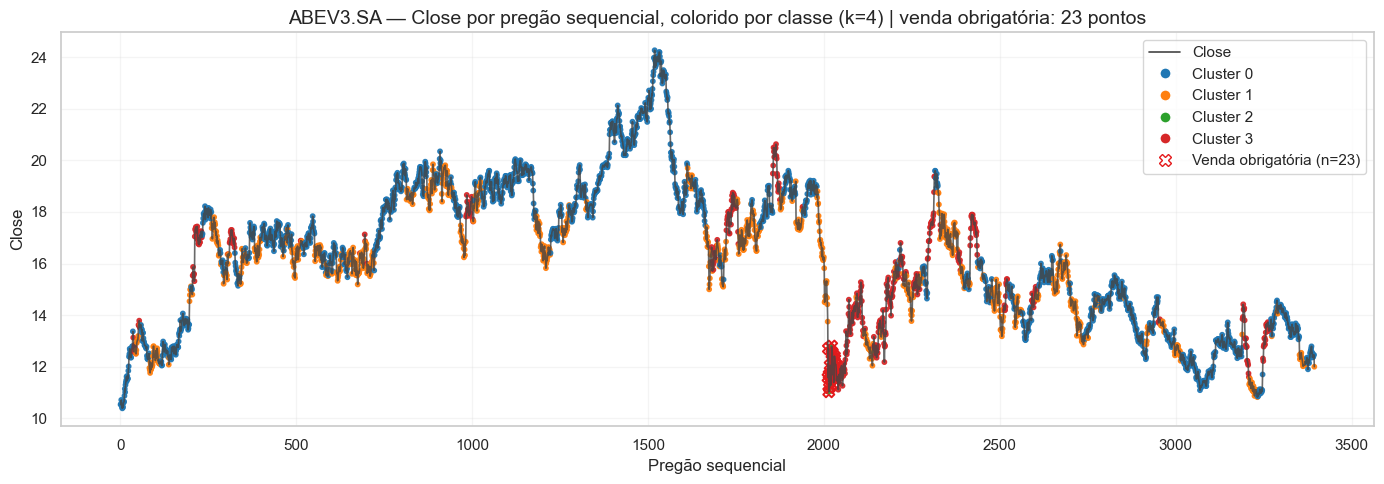

In [61]:
# === Plot ABEV3 por pregão sequencial, colorindo por classe (cluster k=4) ===
import matplotlib.pyplot as plt
import matplotlib as mpl

# Carregar atribuições se não estiver em memória
ass_path = PROJECT_ROOT / '00_data' / '03_final' / 'unsup_close_kmeans4_assignments.parquet'
if 'ass_df' not in globals():
    ass_df = pd.read_parquet(ass_path)

# Selecionar ticker
ticker_plot = 'ABEV3.SA'

df_tk = ass_df[ass_df['ticker'] == ticker_plot].copy()
df_tk['date'] = pd.to_datetime(df_tk['date'])
df_tk = df_tk.sort_values('date')

# Trazer CLOSE
close_series = close_p[ticker_plot].dropna().copy()
close_series.index = pd.to_datetime(close_series.index)

df_tk = df_tk.merge(close_series.rename('close'), left_on='date', right_index=True, how='left')
df_tk = df_tk.dropna(subset=['close'])

# Pregão sequencial
df_tk['seq'] = np.arange(1, len(df_tk)+1)

# Paleta por cluster
palette = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728'}
colors = df_tk['cluster'].map(palette).fillna('#7f7f7f')

plt.figure(figsize=(14, 5))
plt.plot(df_tk['seq'], df_tk['close'], color='#444', linewidth=1.2, alpha=0.8, label='Close')
plt.scatter(df_tk['seq'], df_tk['close'], c=colors, s=10, alpha=0.9, label='Classe (cluster)')

# Marcar pontos de venda obrigatória
vo_mask = (df_tk.get('acao') == 'venda_obrigatoria')
vo_n = int(vo_mask.sum()) if vo_mask is not None else 0
if vo_n > 0:
    plt.scatter(df_tk.loc[vo_mask, 'seq'], df_tk.loc[vo_mask, 'close'],
                marker='X', s=64, facecolors='none', edgecolors='#e41a1c', linewidths=1.4,
                label=f'Venda obrigatória (n={vo_n})')

# Legenda de clusters
handles = [mpl.lines.Line2D([0],[0], marker='o', color='w', label=f'Cluster {c}', markerfacecolor=palette[c], markersize=8) for c in sorted(palette.keys())]
legend_items = [mpl.lines.Line2D([0],[0], color='#444', lw=1.2, label='Close')] + handles
if vo_n > 0:
    legend_items.append(mpl.lines.Line2D([0],[0], marker='X', color='w', label=f'Venda obrigatória (n={vo_n})', markeredgecolor='#e41a1c', markerfacecolor='none', markersize=8, linewidth=0))
plt.legend(handles=legend_items, loc='best')

ttl = f'{ticker_plot} — Close por pregão sequencial, colorido por classe (k=4)'
if vo_n > 0:
    ttl += f' | venda obrigatória: {vo_n} pontos'
plt.title(ttl)
plt.xlabel('Pregão sequencial')
plt.ylabel('Close')
plt.grid(True, alpha=0.2)
plt.tight_layout()

# Salvar figura
fig_path = PROJECT_ROOT / '04_outputs' / f'plot_close_classes_{ticker_plot}.png'
plt.savefig(fig_path, dpi=150)
print('Figura salva em:', fig_path, '| venda_obrigatoria:', vo_n)

In [63]:
# === Plotly interativo: ABEV3 por pregão sequencial colorido por classe (k=4) e marcação de venda obrigatória ===
%pip install plotly
import plotly.graph_objects as go
import plotly.express as px

# Garantir atribuições carregadas
ess_path = PROJECT_ROOT / '00_data' / '03_final' / 'unsup_close_kmeans4_assignments.parquet'
if 'ass_df' not in globals():
    ass_df = pd.read_parquet(ess_path)

# Ticker
ticker_plot = 'ABEV3.SA'

# Preparar base unindo close
df_tk = ass_df[ass_df['ticker'] == ticker_plot].copy()
df_tk['date'] = pd.to_datetime(df_tk['date'])
df_tk = df_tk.sort_values('date')

close_series = close_p[ticker_plot].dropna().copy()
close_series.index = pd.to_datetime(close_series.index)

df_tk = df_tk.merge(close_series.rename('close'), left_on='date', right_index=True, how='left')
df_tk = df_tk.dropna(subset=['close'])

# Pregão sequencial
df_tk['seq'] = np.arange(1, len(df_tk)+1)

# Paleta consistente com matplotlib
palette = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728'}

# Figura
fig = go.Figure()

# Linha do close
fig.add_trace(go.Scatter(
    x=df_tk['seq'], y=df_tk['close'],
    mode='lines', name='Close', line=dict(color='#444', width=1.2), opacity=0.9,
    hovertemplate='Seq %{x}<br>Close %{y:.2f}<br>Data %{customdata|%Y-%m-%d}<extra></extra>',
    customdata=df_tk['date'].dt.strftime('%Y-%m-%d')
))

# Marcadores por cluster
for c in sorted(df_tk['cluster'].dropna().unique().tolist()):
    m = df_tk['cluster'] == c
    fig.add_trace(go.Scatter(
        x=df_tk.loc[m, 'seq'], y=df_tk.loc[m, 'close'],
        mode='markers', name=f'Cluster {c}', marker=dict(color=palette.get(int(c), '#7f7f7f'), size=6),
        hovertemplate=(
            'Seq %{x}<br>Close %{y:.2f}<br>Cluster ' + str(c) +
            '<br>Data %{customdata|%Y-%m-%d}<br>Ação %{meta}<extra></extra>'
        ),
        customdata=df_tk.loc[m, 'date'].dt.strftime('%Y-%m-%d'),
        meta=df_tk.loc[m, 'acao'].fillna('').values
    ))

# Venda obrigatória (marcadores X vazados)
vo_mask = (df_tk.get('acao') == 'venda_obrigatoria')
vo_n = int(vo_mask.sum()) if vo_mask is not None else 0
if vo_n > 0:
    fig.add_trace(go.Scatter(
        x=df_tk.loc[vo_mask, 'seq'], y=df_tk.loc[vo_mask, 'close'],
        mode='markers', name=f'Venda obrigatória (n={vo_n})',
        marker=dict(symbol='x', size=10, color='rgba(0,0,0,0)', line=dict(color='#e41a1c', width=2)),
        hovertemplate='Seq %{x}<br>Close %{y:.2f}<br>Venda obrigatória<br>Data %{customdata|%Y-%m-%d}<extra></extra>',
        customdata=df_tk.loc[vo_mask, 'date'].dt.strftime('%Y-%m-%d')
    ))

ttl = f'{ticker_plot} — Close por pregão sequencial (k=4)'
if vo_n > 0:
    ttl += f' | venda obrigatória: {vo_n} pontos'

fig.update_layout(
    title=ttl,
    xaxis_title='Pregão sequencial',
    yaxis_title='Close',
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0)
)

# Mostrar figura
fig.show()

# Salvar HTML
html_path = PROJECT_ROOT / '04_outputs' / f'plotly_close_classes_{ticker_plot}.html'
fig.write_html(str(html_path), include_plotlyjs='cdn', full_html=True)
print('HTML salvo em:', html_path)


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------------------ --------------------- 4.5/9.8 MB 22.4 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.8 MB 22.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 21.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


HTML salvo em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\04_outputs\plotly_close_classes_ABEV3.SA.html


In [64]:
# === Plotly interativo: ABEV3 — rm (rolling mean) e rv (rolling vol) com clusters (k=4) ===
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Garantir atribuições carregadas
ass_path = PROJECT_ROOT / '00_data' / '03_final' / 'unsup_close_kmeans4_assignments.parquet'
if 'ass_df' not in globals():
    ass_df = pd.read_parquet(ass_path)

# Selecionar ticker
ticker_plot = 'ABEV3.SA'

df_tk = ass_df[ass_df['ticker'] == ticker_plot].copy()
df_tk['date'] = pd.to_datetime(df_tk['date'])
df_tk = df_tk.sort_values('date').dropna(subset=['rm','rv'])

# Pregão sequencial
df_tk['seq'] = np.arange(1, len(df_tk)+1)

palette = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728'}

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.08,
                    subplot_titles=("Rolling mean de retornos (rm, 21d)", "Rolling vol de retornos (rv, 21d)"))

# Linha rm
a_rm = go.Scatter(x=df_tk['seq'], y=df_tk['rm'], mode='lines', name='rm (21d)',
                  line=dict(color='#555', width=1.2),
                  hovertemplate='Seq %{x}<br>rm %{y:.5f}<br>Data %{customdata|%Y-%m-%d}<extra></extra>',
                  customdata=df_tk['date'].dt.strftime('%Y-%m-%d'))
fig.add_trace(a_rm, row=1, col=1)

# Marcadores rm por cluster
for c in sorted(df_tk['cluster'].dropna().unique().tolist()):
    m = df_tk['cluster'] == c
    fig.add_trace(go.Scatter(
        x=df_tk.loc[m, 'seq'], y=df_tk.loc[m, 'rm'], mode='markers', name=f'rm • cluster {c}',
        marker=dict(color=palette.get(int(c), '#7f7f7f'), size=5, opacity=0.7),
        hovertemplate=(
            'Seq %{x}<br>rm %{y:.5f}<br>Cluster ' + str(c) +
            '<br>Data %{customdata|%Y-%m-%d}<br>Ação %{meta}<extra></extra>'
        ),
        customdata=df_tk.loc[m, 'date'].dt.strftime('%Y-%m-%d'),
        meta=df_tk.loc[m, 'acao'].fillna('').values
    ), row=1, col=1)

# Linha rv
a_rv = go.Scatter(x=df_tk['seq'], y=df_tk['rv'], mode='lines', name='rv (21d)',
                  line=dict(color='#777', width=1.2),
                  hovertemplate='Seq %{x}<br>rv %{y:.5f}<br>Data %{customdata|%Y-%m-%d}<extra></extra>',
                  customdata=df_tk['date'].dt.strftime('%Y-%m-%d'))
fig.add_trace(a_rv, row=2, col=1)

# Marcadores rv por cluster
for c in sorted(df_tk['cluster'].dropna().unique().tolist()):
    m = df_tk['cluster'] == c
    fig.add_trace(go.Scatter(
        x=df_tk.loc[m, 'seq'], y=df_tk.loc[m, 'rv'], mode='markers', name=f'rv • cluster {c}',
        marker=dict(color=palette.get(int(c), '#7f7f7f'), size=5, opacity=0.7),
        hovertemplate=(
            'Seq %{x}<br>rv %{y:.5f}<br>Cluster ' + str(c) +
            '<br>Data %{customdata|%Y-%m-%d}<br>Ação %{meta}<extra></extra>'
        ),
        customdata=df_tk.loc[m, 'date'].dt.strftime('%Y-%m-%d'),
        meta=df_tk.loc[m, 'acao'].fillna('').values
    ), row=2, col=1)

# Marcação de venda obrigatória (X) nos dois painéis
vo_mask = (df_tk.get('acao') == 'venda_obrigatoria')
vo_n = int(vo_mask.sum()) if vo_mask is not None else 0
if vo_n > 0:
    for rowi, ycol in [(1,'rm'), (2,'rv')]:
        fig.add_trace(go.Scatter(
            x=df_tk.loc[vo_mask, 'seq'], y=df_tk.loc[vo_mask, ycol],
            mode='markers', name=f'Venda obrigatória (n={vo_n})' if rowi==1 else None,
            marker=dict(symbol='x', size=10, color='rgba(0,0,0,0)', line=dict(color='#e41a1c', width=2)),
            hovertemplate=f'Seq %{{x}}<br>{ycol} %{{y:.5f}}<br>Venda obrigatória<br>Data %{{customdata|%Y-%m-%d}}<extra></extra>',
            customdata=df_tk.loc[vo_mask, 'date'].dt.strftime('%Y-%m-%d')
        ), row=rowi, col=1)

fig.update_layout(
    title=f'{ticker_plot} — rm e rv por pregão sequencial (k=4)'+(f' | venda obrigatória: {vo_n} pontos' if vo_n>0 else ''),
    xaxis_title='Pregão sequencial',
    yaxis_title='rm (21d)',
    xaxis2_title='Pregão sequencial',
    yaxis2_title='rv (21d)',
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.12, xanchor='left', x=0)
)

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)

fig.show()

# Salvar HTML
html_path = PROJECT_ROOT / '04_outputs' / f'plotly_rm_rv_{ticker_plot}.html'
fig.write_html(str(html_path), include_plotlyjs='cdn', full_html=True)
print('HTML salvo em:', html_path)

HTML salvo em: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\04_outputs\plotly_rm_rv_ABEV3.SA.html


# Análise gráfica: sequências de quedas no Close (ABEV3)

Este gráfico interativo em Plotly exibe somente as sequências consecutivas em que o Close caiu (dias com retorno negativo). Use a caixa de seleção (dropdown) para ocultar do gráfico todas as sequências com comprimento menor ou igual a 3, 4 ou 5 pregões.

- O controle "Ocultar ≤ N" remove do gráfico as sequências com N dias ou menos; permanecem visíveis apenas as sequências com mais de N dias.
- As sequências são plotadas como linhas segmentadas (com quebras entre sequências) e coloridas por comprimento (número de dias consecutivos de queda).
- O arquivo HTML interativo será salvo em `04_outputs/plotly_down_sequences_ABEV3.SA.html`. Se já houver preços carregados no notebook (`close_p`), o código os usará; caso contrário, tentará ler o parquet de ABEV3 nos diretórios de dados.

In [66]:
# Plotly: apenas sequências de quedas no Close para ABEV3 com filtro por comprimento (3-5)
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.colors import qualitative

# 1) Tenta usar close_p do notebook, se existir, para ABEV3
_df = None
try:
    if 'close_p' in globals() and isinstance(close_p, pd.DataFrame):
        cand = close_p.copy()
        # Estruturas comuns: MultiIndex (date, ticker) com coluna 'close' OU wide com colunas por ticker
        if {'date','ticker','close'}.issubset({c.lower() for c in cand.reset_index().columns}):
            tmp = cand.reset_index()
            # normaliza nomes
            tmp.columns = [c.lower() for c in tmp.columns]
            df_abev = tmp[tmp['ticker'].str.upper().isin(['ABEV3.SA','ABEV3'])][['date','close']].copy()
            if len(df_abev) > 0:
                _df = df_abev.sort_values('date').reset_index(drop=True)
        elif 'ABEV3.SA' in cand.columns or 'ABEV3' in cand.columns:
            col = 'ABEV3.SA' if 'ABEV3.SA' in cand.columns else 'ABEV3'
            df_abev = cand[[col]].copy()
            df_abev = df_abev.reset_index().rename(columns={'index':'date', col:'close'})
            _df = df_abev.sort_values('date').reset_index(drop=True)
except Exception:
    _df = None

# 2) Se não achou via close_p, procura parquets locais
if _df is None or _df.empty:
    parquet_candidates = [
        os.path.join('00_data', '02_adequado', 'abev3_sa_1d.parquet'),
        os.path.join('00_data', '01_bruto', 'abev3_sa_1d.parquet'),
    ]
    path = next((p for p in parquet_candidates if os.path.exists(p)), None)
    if path is None:
        raise FileNotFoundError("Não encontrei dados de ABEV3: nem em close_p do notebook, nem nos parquets padrão. Ajuste o caminho no código.")
    raw = pd.read_parquet(path)
    # tenta detectar colunas
    date_col = next((c for c in raw.columns if c.lower() in ('date','data','session','trading_day')), None)
    close_col = next((c for c in raw.columns if c.lower() in ('close','fechamento','adj_close','close_p')), None)
    if date_col is None or close_col is None:
        raise ValueError(f"Não identifiquei as colunas de data/close neste parquet. Colunas: {raw.columns.tolist()}")
    _df = raw[[date_col, close_col]].rename(columns={date_col:'date', close_col:'close'}).sort_values('date').reset_index(drop=True)

# Garantias de tipo/ordem
_df['date'] = pd.to_datetime(_df['date'])
_df = _df.sort_values('date').reset_index(drop=True)

# Retorno diário e flag de queda
_df['ret'] = _df['close'].pct_change()
_df['down'] = _df['ret'] < 0

# Identifica sequências consecutivas de queda
change = (_df['down'] != _df['down'].shift()).cumsum()
_df['seq_id'] = np.where(_df['down'], change, np.nan)
seq_lengths = _df.groupby('seq_id', dropna=True)['down'].sum().rename('seq_len')
_df = _df.merge(seq_lengths, left_on='seq_id', right_index=True, how='left')
seq_df = _df[_df['down'] & _df['seq_id'].notna()].copy()

# Metadados por sequência
seq_meta = seq_df.groupby('seq_id').agg(
    seq_len=('seq_len','first'),
    start_date=('date','min'),
    end_date=('date','max'),
    start_close=('close','first'),
    end_close=('close','last')
).reset_index()
seq_meta['dd_pct'] = (seq_meta['end_close']/seq_meta['start_close'] - 1.0)

# Paleta por comprimento
unique_lens = sorted(seq_meta['seq_len'].unique())
palette = qualitative.Set2 if len(unique_lens) <= len(qualitative.Set2) else qualitative.Plotly
color_map = {int(L): palette[i % len(palette)] for i, L in enumerate(unique_lens)}

# Constrói um trace por sequência (facilita filtrar por comprimento)
traces = []
visibility_by_threshold = {3: [], 4: [], 5: []}

for _, row in seq_meta.iterrows():
    sid = row['seq_id']
    L = int(row['seq_len'])
    srows = seq_df[seq_df['seq_id'] == sid]
    x = srows['date']
    y = srows['close']
    color = color_map.get(L, '#444')
    name = f"{L} dias de queda — início {row['start_date'].date()}"

    traces.append(
        go.Scatter(
            x=x, y=y,
            mode='lines+markers',
            name=name,
            line=dict(color=color, width=2),
            marker=dict(size=4, color=color),
            hovertemplate=(
                "Data: %{x|%Y-%m-%d}<br>Close: %{y:.2f}<br>Comprimento: " + str(L) + "<extra></extra>"
            )
        )
    )
    for N in visibility_by_threshold.keys():
        visibility_by_threshold[N].append(L > N)

base_visibility = [True]*len(traces)

fig = go.Figure(data=traces)
buttons = [
    dict(
        label="Mostrar tudo",
        method="update",
        args=[{"visible": base_visibility}, {"title": "ABEV3 — Sequências de quedas (todas)"}]
    )
]
for N in [3,4,5]:
    buttons.append(
        dict(
            label=f"Ocultar ≤ {N}",
            method="update",
            args=[{"visible": visibility_by_threshold[N]}, {"title": f"ABEV3 — Sequências de quedas (len > {N})"}]
        )
    )

fig.update_layout(
    title="ABEV3 — Sequências de quedas (todas)",
    xaxis_title="Data",
    yaxis_title="Close",
    template="plotly_white",
    legend_title="Sequências",
    updatemenus=[
        dict(
            type="dropdown",
            x=1.0, xanchor="right",
            y=1.2, yanchor="top",
            showactive=True,
            buttons=buttons
        )
    ],
    hovermode="x unified"
)

# Exporta HTML
os.makedirs('04_outputs', exist_ok=True)
html_path = os.path.join('04_outputs', 'plotly_down_sequences_ABEV3.SA.html')
fig.write_html(html_path, include_plotlyjs='cdn')

fig.show()
print(f"Gráfico salvo em: {html_path}")

C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\1870322532.py:51: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Gráfico salvo em: 04_outputs\plotly_down_sequences_ABEV3.SA.html


# Inclinação em pontos de inflexão (ABEVE3): 2 vs 3 pontos

Objetivo:
- Identificar pontos de inflexão (mudança de direção do retorno diário: sobe→cai ou cai→sobe).
- Calcular a inclinação da reta entre o ponto de inflexão e os próximos pontos:
  - Inclinação 2P: linha entre (inflect, inflect+1)
  - Inclinação 3P: regressão linear em (inflect, inflect+1, inflect+2)
- Avaliar o comportamento da inclinação nas grandes quedas e se ela pode indicar "venda_obrigatória" (se disponível) ou um drawdown futuro (fallback).

Interativo:
- Gráfico Plotly com Close e marcadores nos pontos de inflexão, coloridos pela inclinação (2P ou 3P), com overlay de VO quando disponível.
- HTML salvo em `04_outputs/plotly_inflection_slopes_ABEV3.SA.html`.

In [69]:
# Pontos de inflexão e inclinações (2P e 3P) para ABEV3; métricas simples e gráfico interativo
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# 1) Obter série de ABEV3 (usa close_p se existir; senão parquet)
_df = None
try:
    if 'close_p' in globals() and isinstance(close_p, pd.DataFrame):
        cand = close_p.copy()
        if {'date','ticker','close'}.issubset({c.lower() for c in cand.reset_index().columns}):
            tmp = cand.reset_index()
            tmp.columns = [c.lower() for c in tmp.columns]
            df_abev = tmp[tmp['ticker'].str.upper().isin(['ABEV3.SA','ABEV3'])][['date','close']].copy()
            if len(df_abev) > 0:
                _df = df_abev.sort_values('date').reset_index(drop=True)
        elif 'ABEV3.SA' in cand.columns or 'ABEV3' in cand.columns:
            col = 'ABEV3.SA' if 'ABEV3.SA' in cand.columns else 'ABEV3'
            df_abev = cand[[col]].copy().reset_index().rename(columns={'index':'date', col:'close'})
            _df = df_abev.sort_values('date').reset_index(drop=True)
except Exception:
    _df = None

if _df is None or _df.empty:
    parquet_candidates = [
        os.path.join('00_data', '02_adequado', 'abev3_sa_1d.parquet'),
        os.path.join('00_data', '01_bruto', 'abev3_sa_1d.parquet'),
    ]
    path = next((p for p in parquet_candidates if os.path.exists(p)), None)
    if path is None:
        raise FileNotFoundError("Não encontrei ABEV3 via close_p nem parquets padrão. Ajuste o caminho.")
    raw = pd.read_parquet(path)
    date_col = next((c for c in raw.columns if c.lower() in ('date','data','session','trading_day')), None)
    close_col = next((c for c in raw.columns if c.lower() in ('close','fechamento','adj_close','close_p')), None)
    if date_col is None or close_col is None:
        raise ValueError(f"Colunas de data/close não detectadas. Colunas: {raw.columns.tolist()}")
    _df = raw[[date_col, close_col]].rename(columns={date_col:'date', close_col:'close'}).sort_values('date').reset_index(drop=True)

_df['date'] = pd.to_datetime(_df['date'])
_df = _df.sort_values('date').reset_index(drop=True)

# 2) Retornos e pontos de inflexão: mudança de sinal do retorno
_df['ret'] = _df['close'].pct_change()
# Direção: +1 (sobe), -1 (cai), 0 (sem variação)
dirn = np.sign(_df['ret'].fillna(0.0))
# inflexão quando dirn muda de sinal entre t-1 e t e o valor atual não é 0
inflect = (dirn.shift(1).fillna(0) != dirn) & (dirn != 0)
_df['inflect'] = inflect

# 3) Calcular inclinações a partir do ponto de inflexão
# Inclinação 2P: (close[t+1] - close[t])
# Inclinação 3P: regressão linear em pontos t, t+1, t+2 (x = 0,1,2)
slopes = []
for i in np.where(_df['inflect'].values)[0]:
    # slope2
    if i+1 < len(_df) and pd.notna(_df.loc[i, 'close']) and pd.notna(_df.loc[i+1, 'close']):
        slope2 = (_df.loc[i+1, 'close'] - _df.loc[i, 'close'])
    else:
        slope2 = np.nan
    # slope3
    if i+2 < len(_df):
        y = _df.loc[i:i+2, 'close']
        if not y.isna().any():
            X = np.array([0,1,2]).reshape(-1,1)
            lr = LinearRegression().fit(X, y.values)
            slope3 = lr.coef_[0]
        else:
            slope3 = np.nan
    else:
        slope3 = np.nan
    slopes.append((i, slope2, slope3))

slopes_df = pd.DataFrame(slopes, columns=['idx','slope2','slope3'])
_df = _df.join(slopes_df.set_index('idx'), how='left')

# 4) Definir "grande queda" como sequência de queda com len >= 3 (ajuste se quiser)
down = _df['ret'] < 0
change = (down != down.shift()).cumsum()
seq_id = np.where(down, change, np.nan)
_df['seq_id'] = seq_id
seq_len = _df.groupby('seq_id', dropna=True)['ret'].count()
_df = _df.merge(seq_len.rename('seq_len_down'), left_on='seq_id', right_index=True, how='left')
_df['big_drop_seq'] = _df['seq_len_down'] >= 3

# 5) Opcional: mapear "venda_obrigatória" se disponível
_df['venda_obrigatoria'] = False
try:
    if 'ass_df' in globals() and isinstance(ass_df, pd.DataFrame):
        tmp = ass_df.copy()
        tmp.columns = [c.lower() for c in tmp.columns]
        if {'date','ticker'}.issubset(tmp.columns):
            vo_mask = (
                (tmp['ticker'].str.upper().isin(['ABEV3.SA','ABEV3'])) &
                (tmp.get('acao','').astype(str).str.contains('venda', case=False, na=False))
            )
            vo_dates = set(pd.to_datetime(tmp.loc[vo_mask, 'date']).dt.normalize())
            _df['venda_obrigatoria'] = _df['date'].dt.normalize().isin(vo_dates)
except Exception:
    pass

# 6) Pequena avaliação: a inclinação prediz "VO" ou uma futura queda?
label = _df['venda_obrigatoria'].copy()
if not label.any():
    fut3 = _df['big_drop_seq'].shift(-1).fillna(False) | _df['big_drop_seq'].shift(-2).fillna(False) | _df['big_drop_seq'].shift(-3).fillna(False)
    label = fut3

# Regras simples com thresholds por quantis (ignora NaNs nas inclinações)
q2 = _df['slope2'].dropna().quantile([0.1, 0.2, 0.3]).to_dict() if _df['slope2'].notna().any() else {}
q3 = _df['slope3'].dropna().quantile([0.1, 0.2, 0.3]).to_dict() if _df['slope3'].notna().any() else {}

summ_rows = []
for kind, s, qs in [('slope2', _df['slope2'], q2), ('slope3', _df['slope3'], q3)]:
    for qn, thr in qs.items():
        pred = s <= thr
        pred = pred.fillna(False)
        lab = label.fillna(False)
        tp = int((pred & lab).sum())
        fp = int((pred & ~lab).sum())
        fn = int((~pred & lab).sum())
        tn = int((~pred & ~lab).sum())
        prec = tp/(tp+fp) if (tp+fp)>0 else np.nan
        rec = tp/(tp+fn) if (tp+fn)>0 else np.nan
        summ_rows.append({'kind':kind,'quantile':float(qn),'thr':float(thr),'precision':prec,'recall':rec,'tp':tp,'fp':fp,'fn':fn,'tn':tn})
summary = pd.DataFrame(summ_rows)
print("Resumo de métrica simples por inclinação e quantil:\n", summary)

# 7) Plot interativo: Close com marcadores nos pontos de inflexão, coloridos pela inclinação escolhida
use_kind = 'slope3'  # alterne para 'slope2' se preferir
sl = _df[use_kind]

# Se não há valores suficientes, evite erros
drop_sl = sl.dropna()
if len(drop_sl) >= 5:
    bins = np.nanpercentile(drop_sl, [10,30,50,70,90])
else:
    mn, mx = (float(np.nanmin(drop_sl)) if len(drop_sl)>0 else -1,
              float(np.nanmax(drop_sl)) if len(drop_sl)>0 else 1)
    bins = np.array([mn + (mx-mn)*q for q in [0.2,0.4,0.6,0.8,0.9]])

labels = ['muito negativa','negativa','leve','positiva','muito positiva','extrema']
colors = ['#8b0000','#d62728','#ff9896','#98df8a','#2ca02c','#006400']
cat = pd.cut(sl, bins=[-np.inf, *bins, np.inf], labels=labels)
color_map = {lab: col for lab, col in zip(labels, colors)}

infl_df = _df[_df['inflect']].copy()
infl_df['cat'] = cat.loc[infl_df.index]

tr_close = go.Scatter(x=_df['date'], y=_df['close'], mode='lines', name='Close', line=dict(color='#1f77b4'))
tr_points = []
for lab in labels:
    sub = infl_df[infl_df['cat']==lab]
    tr_points.append(
        go.Scatter(
            x=sub['date'], y=sub['close'], mode='markers', name=f'Inflect ({lab})',
            marker=dict(color=color_map[lab], size=8, symbol='circle'),
            text=sub[use_kind].round(4).astype(str),
            hovertemplate=(
                "Data: %{x|%Y-%m-%d}<br>Close: %{y:.2f}<br>" +
                use_kind + ": %{text}" +
                "<extra></extra>"
            )
        )
    )

tr_vo = None
if _df['venda_obrigatoria'].any():
    vo = _df[_df['venda_obrigatoria']]
    tr_vo = go.Scatter(x=vo['date'], y=vo['close'], mode='markers', name='Venda obrigatória',
                       marker=dict(color='black', size=11, symbol='x'))

fig = go.Figure(data=[tr_close, *tr_points] + ([tr_vo] if tr_vo is not None else []))
fig.update_layout(
    title=f"ABEV3 — Pontos de inflexão com {use_kind}",
    xaxis_title="Data", yaxis_title="Close",
    template='plotly_white', hovermode='x unified'
)

# Salva HTML
os.makedirs('04_outputs', exist_ok=True)
html_path = os.path.join('04_outputs', 'plotly_inflection_slopes_ABEV3.SA.html')
fig.write_html(html_path, include_plotlyjs='cdn')
fig.show()
print(f"Gráfico salvo em: {html_path}")

C:\Users\wilso\AppData\Local\Temp\ipykernel_14900\1504946387.py:45: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Resumo de métrica simples por inclinação e quantil:
      kind  quantile       thr  precision    recall  tp   fp  fn    tn
0  slope2       0.1 -0.300000   0.022099  0.173913   4  177  19  3217
1  slope2       0.2 -0.180000   0.021978  0.347826   8  356  15  3038
2  slope2       0.3 -0.110000   0.014842  0.347826   8  531  15  2863
3  slope3       0.1 -0.200000   0.022099  0.173913   4  177  19  3217
4  slope3       0.2 -0.126193   0.011142  0.173913   4  355  19  3039
5  slope3       0.3 -0.080000   0.011091  0.260870   6  535  17  2859


Gráfico salvo em: 04_outputs\plotly_inflection_slopes_ABEV3.SA.html


In [70]:
# Converter silver_close.parquet em silver_close.csv
import os
from pathlib import Path
import pandas as pd

# 1) Descobrir o caminho do Parquet
src_path = None
paths_tentados = []

# Preferir variáveis globais definidas no notebook
try:
    if 'SILVER_CLOSE_PATH' in globals() and SILVER_CLOSE_PATH is not None:
        p = Path(str(SILVER_CLOSE_PATH))
        paths_tentados.append(p)
        if p.exists():
            src_path = p
    if src_path is None and 'SILVER_CLOSE_B3_PATH' in globals() and SILVER_CLOSE_B3_PATH is not None:
        p = Path(str(SILVER_CLOSE_B3_PATH))
        paths_tentados.append(p)
        if p.exists():
            src_path = p
except Exception:
    pass

# Busca por nome padrão, se ainda não encontrado
if src_path is None:
    raiz = Path('.')
    candidatos = list(raiz.glob('**/silver_close.parquet'))
    if candidatos:
        src_path = candidatos[0]
        paths_tentados.append(src_path)

# 2) Se ainda não houver arquivo, tentar DataFrame em memória
if src_path is None:
    if 'close_silver' in globals() and isinstance(close_silver, pd.DataFrame):
        df = close_silver.copy()
        # Se existe SILVER_CLOSE_PATH, salvamos no mesmo diretório
        if 'SILVER_CLOSE_PATH' in globals() and SILVER_CLOSE_PATH is not None:
            out_path = Path(str(SILVER_CLOSE_PATH)).with_suffix('.csv')
        else:
            out_path = Path('00_data') / '02_adequado' / 'silver_close.csv'
        out_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_path, index=False)
        print(f"Gerado a partir do DataFrame em memória: {out_path} | linhas={len(df):,}, colunas={len(df.columns)}")
    else:
        raise FileNotFoundError(
            "Não encontrei 'silver_close.parquet' nem o DataFrame 'close_silver'. Caminhos tentados: " + \
            ", ".join(map(str, paths_tentados))
        )
else:
    # 3) Ler Parquet e escrever CSV ao lado
    df = pd.read_parquet(src_path)
    out_path = src_path.with_suffix('.csv')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)
    print(f"Convertido: {src_path} -> {out_path} | linhas={len(df):,}, colunas={len(df.columns)}")

Convertido: G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close.parquet -> G:\Drives compartilhados\BOLSA_2026\a_bolsa2026_gemini\00_data\02_curado\silver_close.csv | linhas=3,588, colunas=32
